In [ ]:
# Analysis for Telco Customer Churn Prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import os
from IPython.display import Image, display

# Ensure matplotlib displays inline
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for consistent plot styling
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

# Define base directory and ensure it exists
BASE_DIR = r"C:\Users\Lewis\Documents\High_Dimensional_Stat_Project"
if not os.path.exists(BASE_DIR):
    os.makedirs(BASE_DIR)
    print(f"Created directory: {BASE_DIR}")
os.chdir(BASE_DIR)
print("Working directory:", os.getcwd())

# Function to verify file creation and display content
def verify_and_display_file(path, is_image=False):
    if os.path.exists(path):
        print(f"File saved successfully: {path}")
        if is_image:
            display(Image(filename=path))
        else:
            df = pd.read_csv(path)
            display(df.head())  # Display first few rows
    else:
        print(f"Error: File not found at {path}")

Working directory: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project


In [10]:
# Step 1: Data Loading and Preprocessing
print("\nStep 1: Data Loading and Preprocessing")
input_path = os.path.join(BASE_DIR, "WA_Fn-UseC_-Telco-Customer-Churn.csv")
if not os.path.exists(input_path):
    raise FileNotFoundError(f"The file {input_path} does not exist.")
data = pd.read_csv(input_path)

# Inspect dataset
print("Dataset Info:")
display(data.info())

# Handle missing values
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
if data['TotalCharges'].isnull().sum() > 0:
    total_charges_median = data['TotalCharges'].median()
    data['TotalCharges'] = data['TotalCharges'].fillna(total_charges_median)
data = data.drop(columns=['customerID'])

# Encode categorical variables
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Churn')
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
data_encoded['Churn'] = data_encoded['Churn'].map({'No': 0, 'Yes': 1})

# Standardize numerical features
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
data_encoded[numerical_cols] = scaler.fit_transform(data_encoded[numerical_cols])

# Save and display preprocessed dataset
output_path = os.path.join(BASE_DIR, "telco_churn_preprocessed.csv")
data_encoded.to_csv(output_path, index=False)
verify_and_display_file(output_path)


Step 1: Data Loading and Preprocessing
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   o

None

File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\telco_churn_preprocessed.csv


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,-1.277445,-1.160323,-0.994242,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,0.066327,-0.259629,-0.173244,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,-1.236724,-0.362660,-0.959674,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,0.514251,-0.746535,-0.194766,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,-1.236724,0.197365,-0.940470,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False



Step 2: Exploratory Data Analysis
File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\numerical_summary.csv


,Unnamed: 0,tenure,MonthlyCharges,TotalCharges
0,count,7.043000e+03,7.043000e+03,7.043000e+03
1,mean,-1.916841e-17,-6.204512e-17,-1.462852e-17
2,std,1.000071e+00,1.000071e+00,1.000071e+00
3,min,-1.318165e+00,-1.545860e+00,-9.991203e-01
4,25%,-9.516817e-01,-9.725399e-01,-8.298459e-01


Overall Churn Rate: 26.54%
File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\histogram_tenure.png


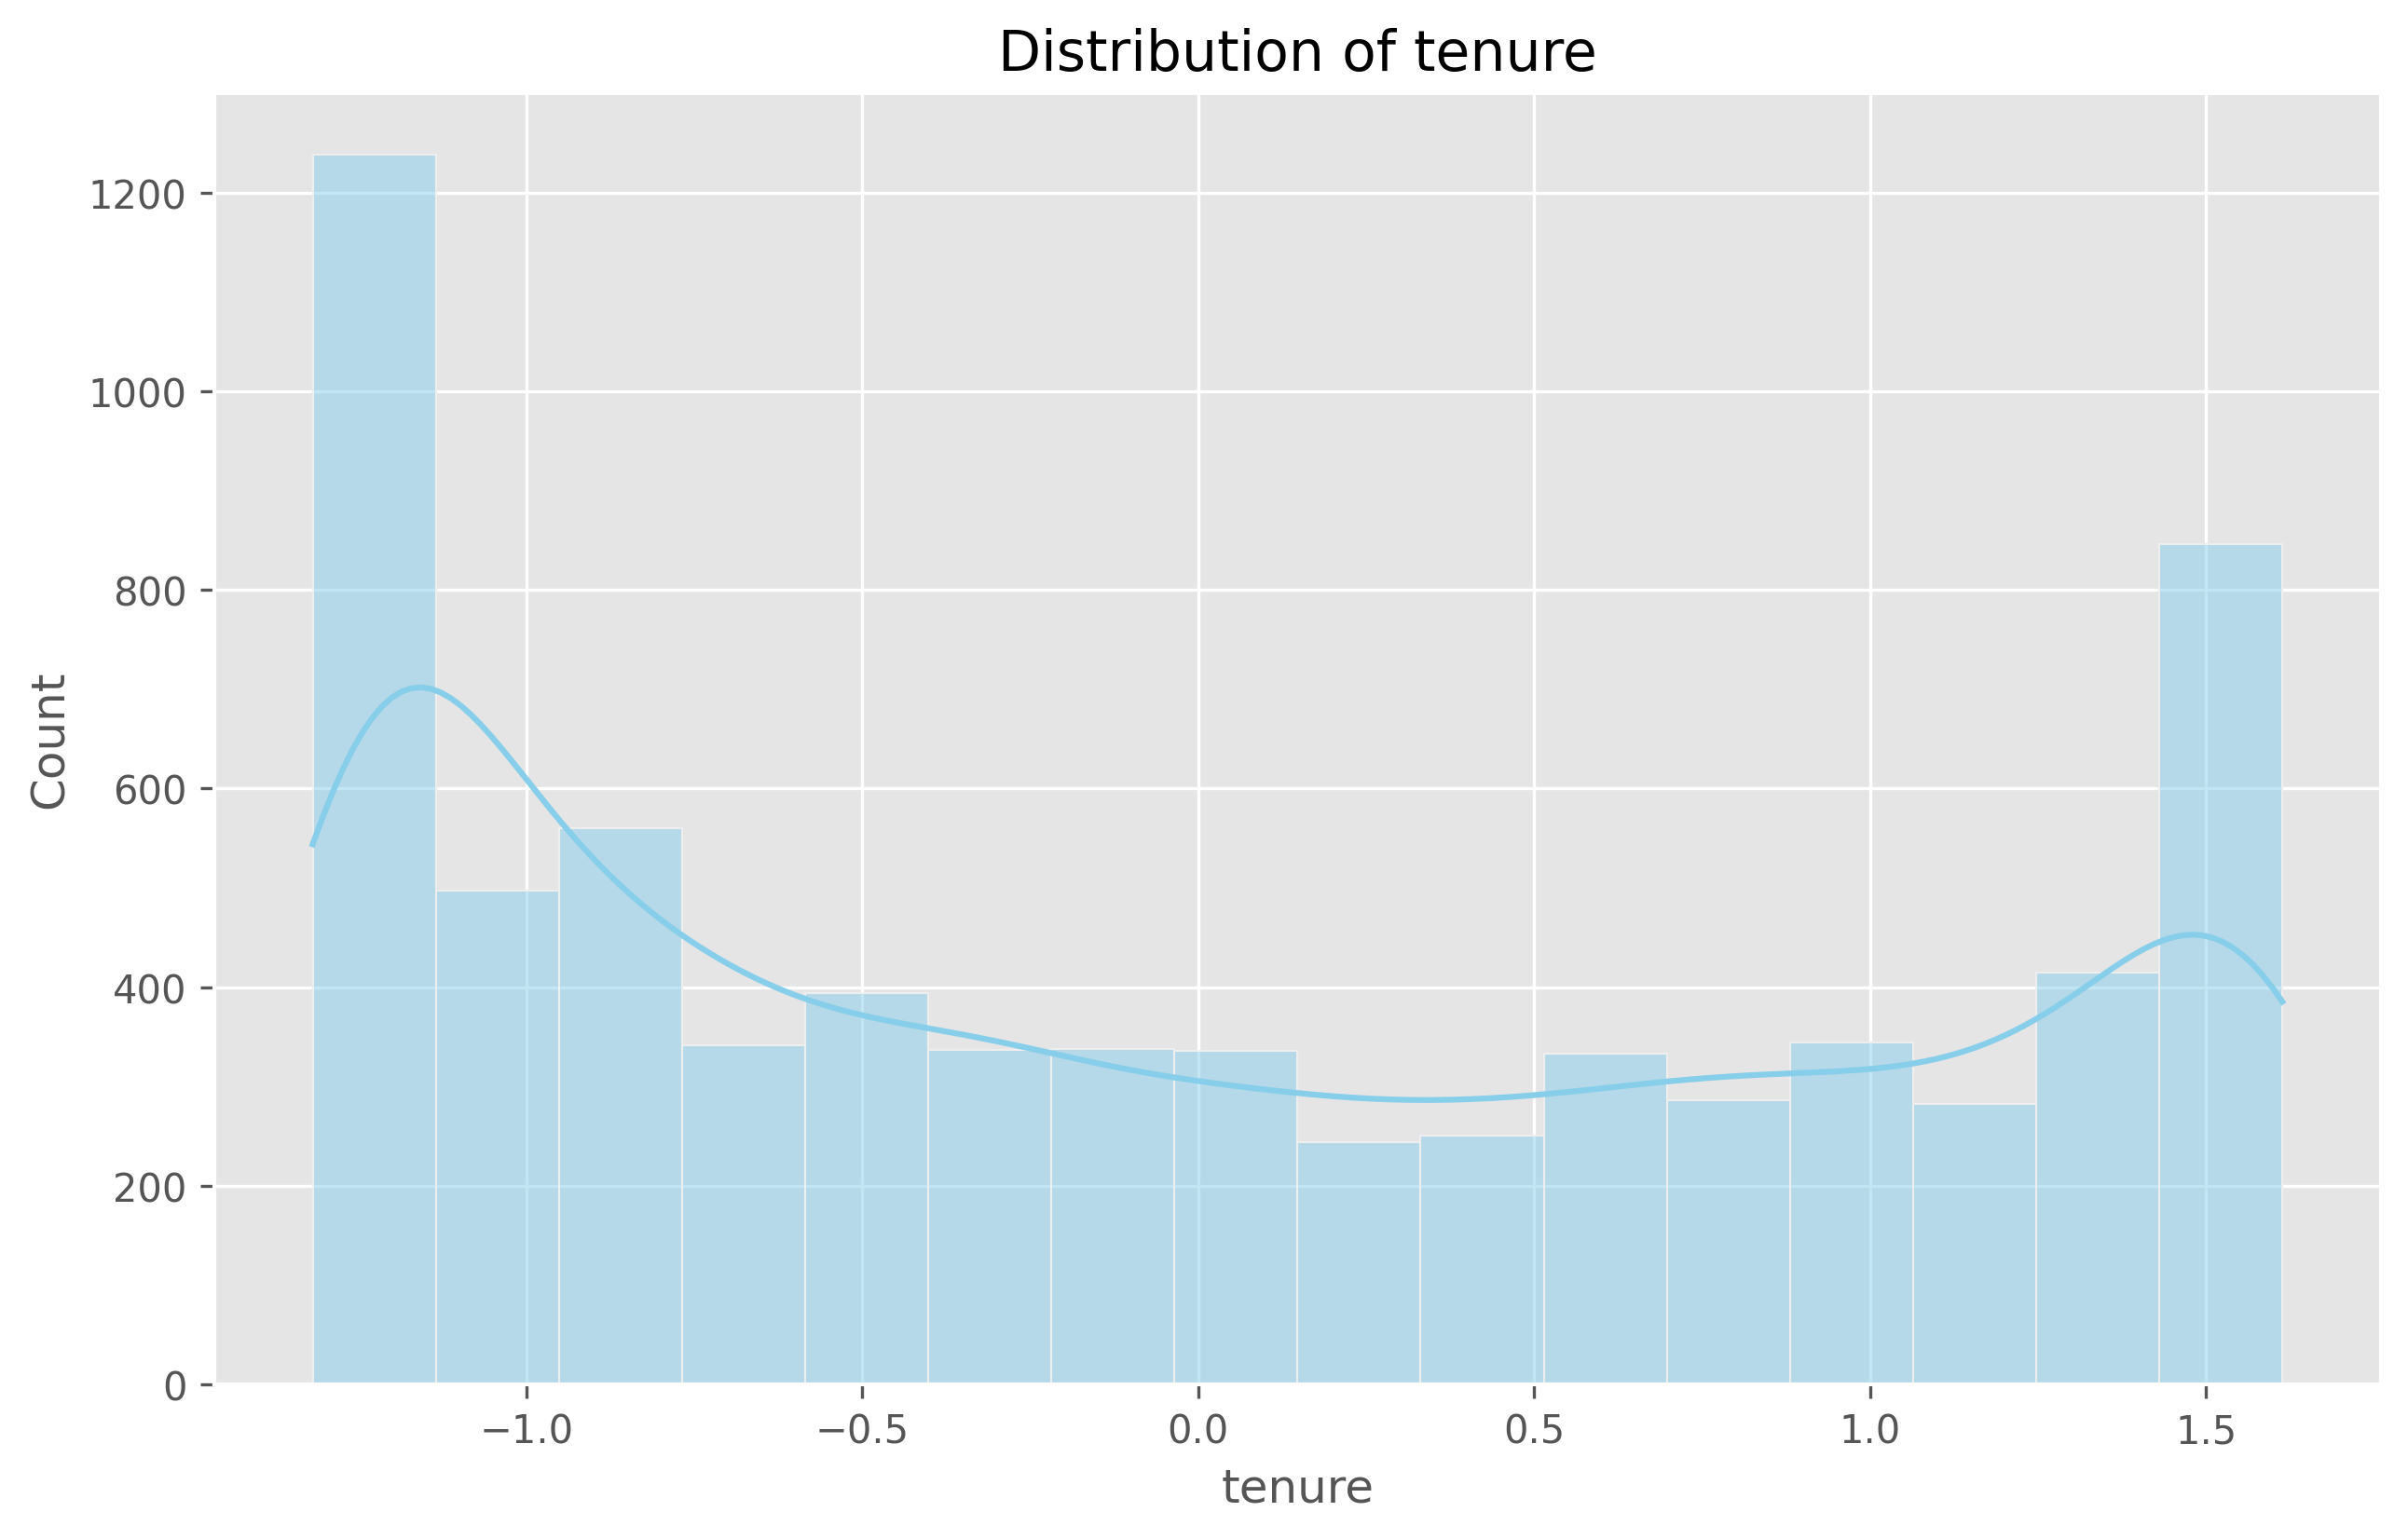

File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\histogram_monthlycharges.png


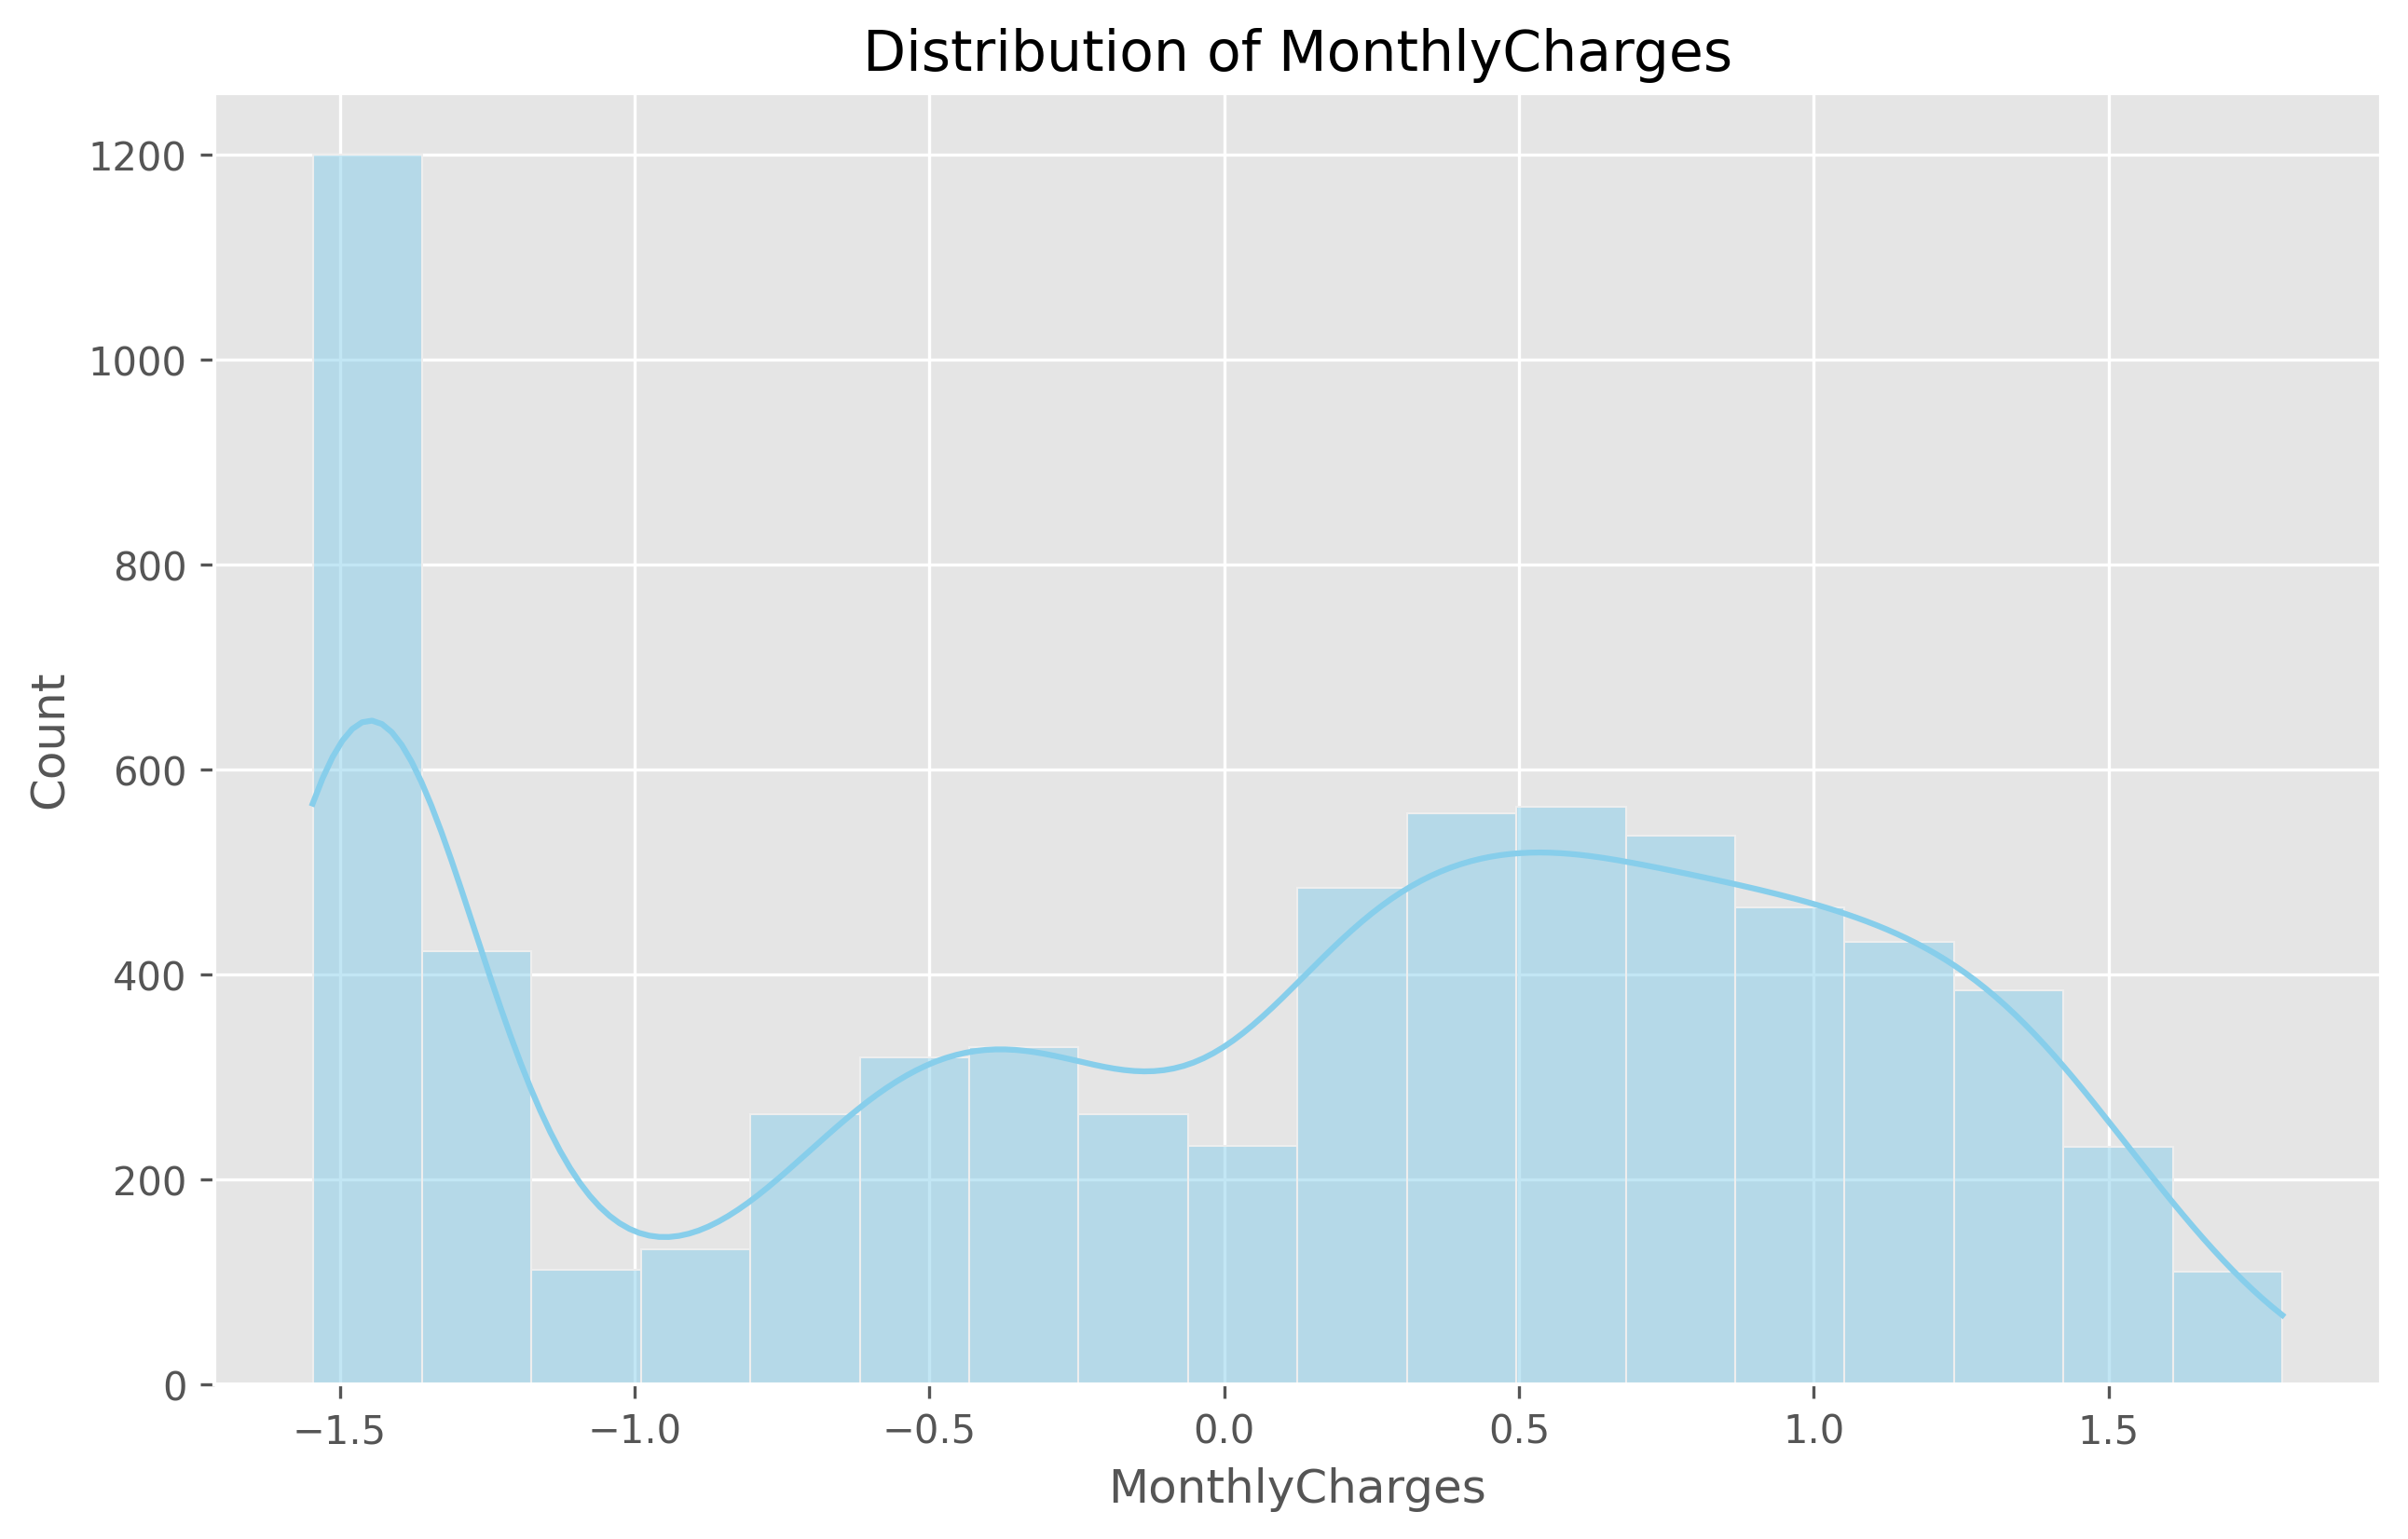

File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\histogram_totalcharges.png


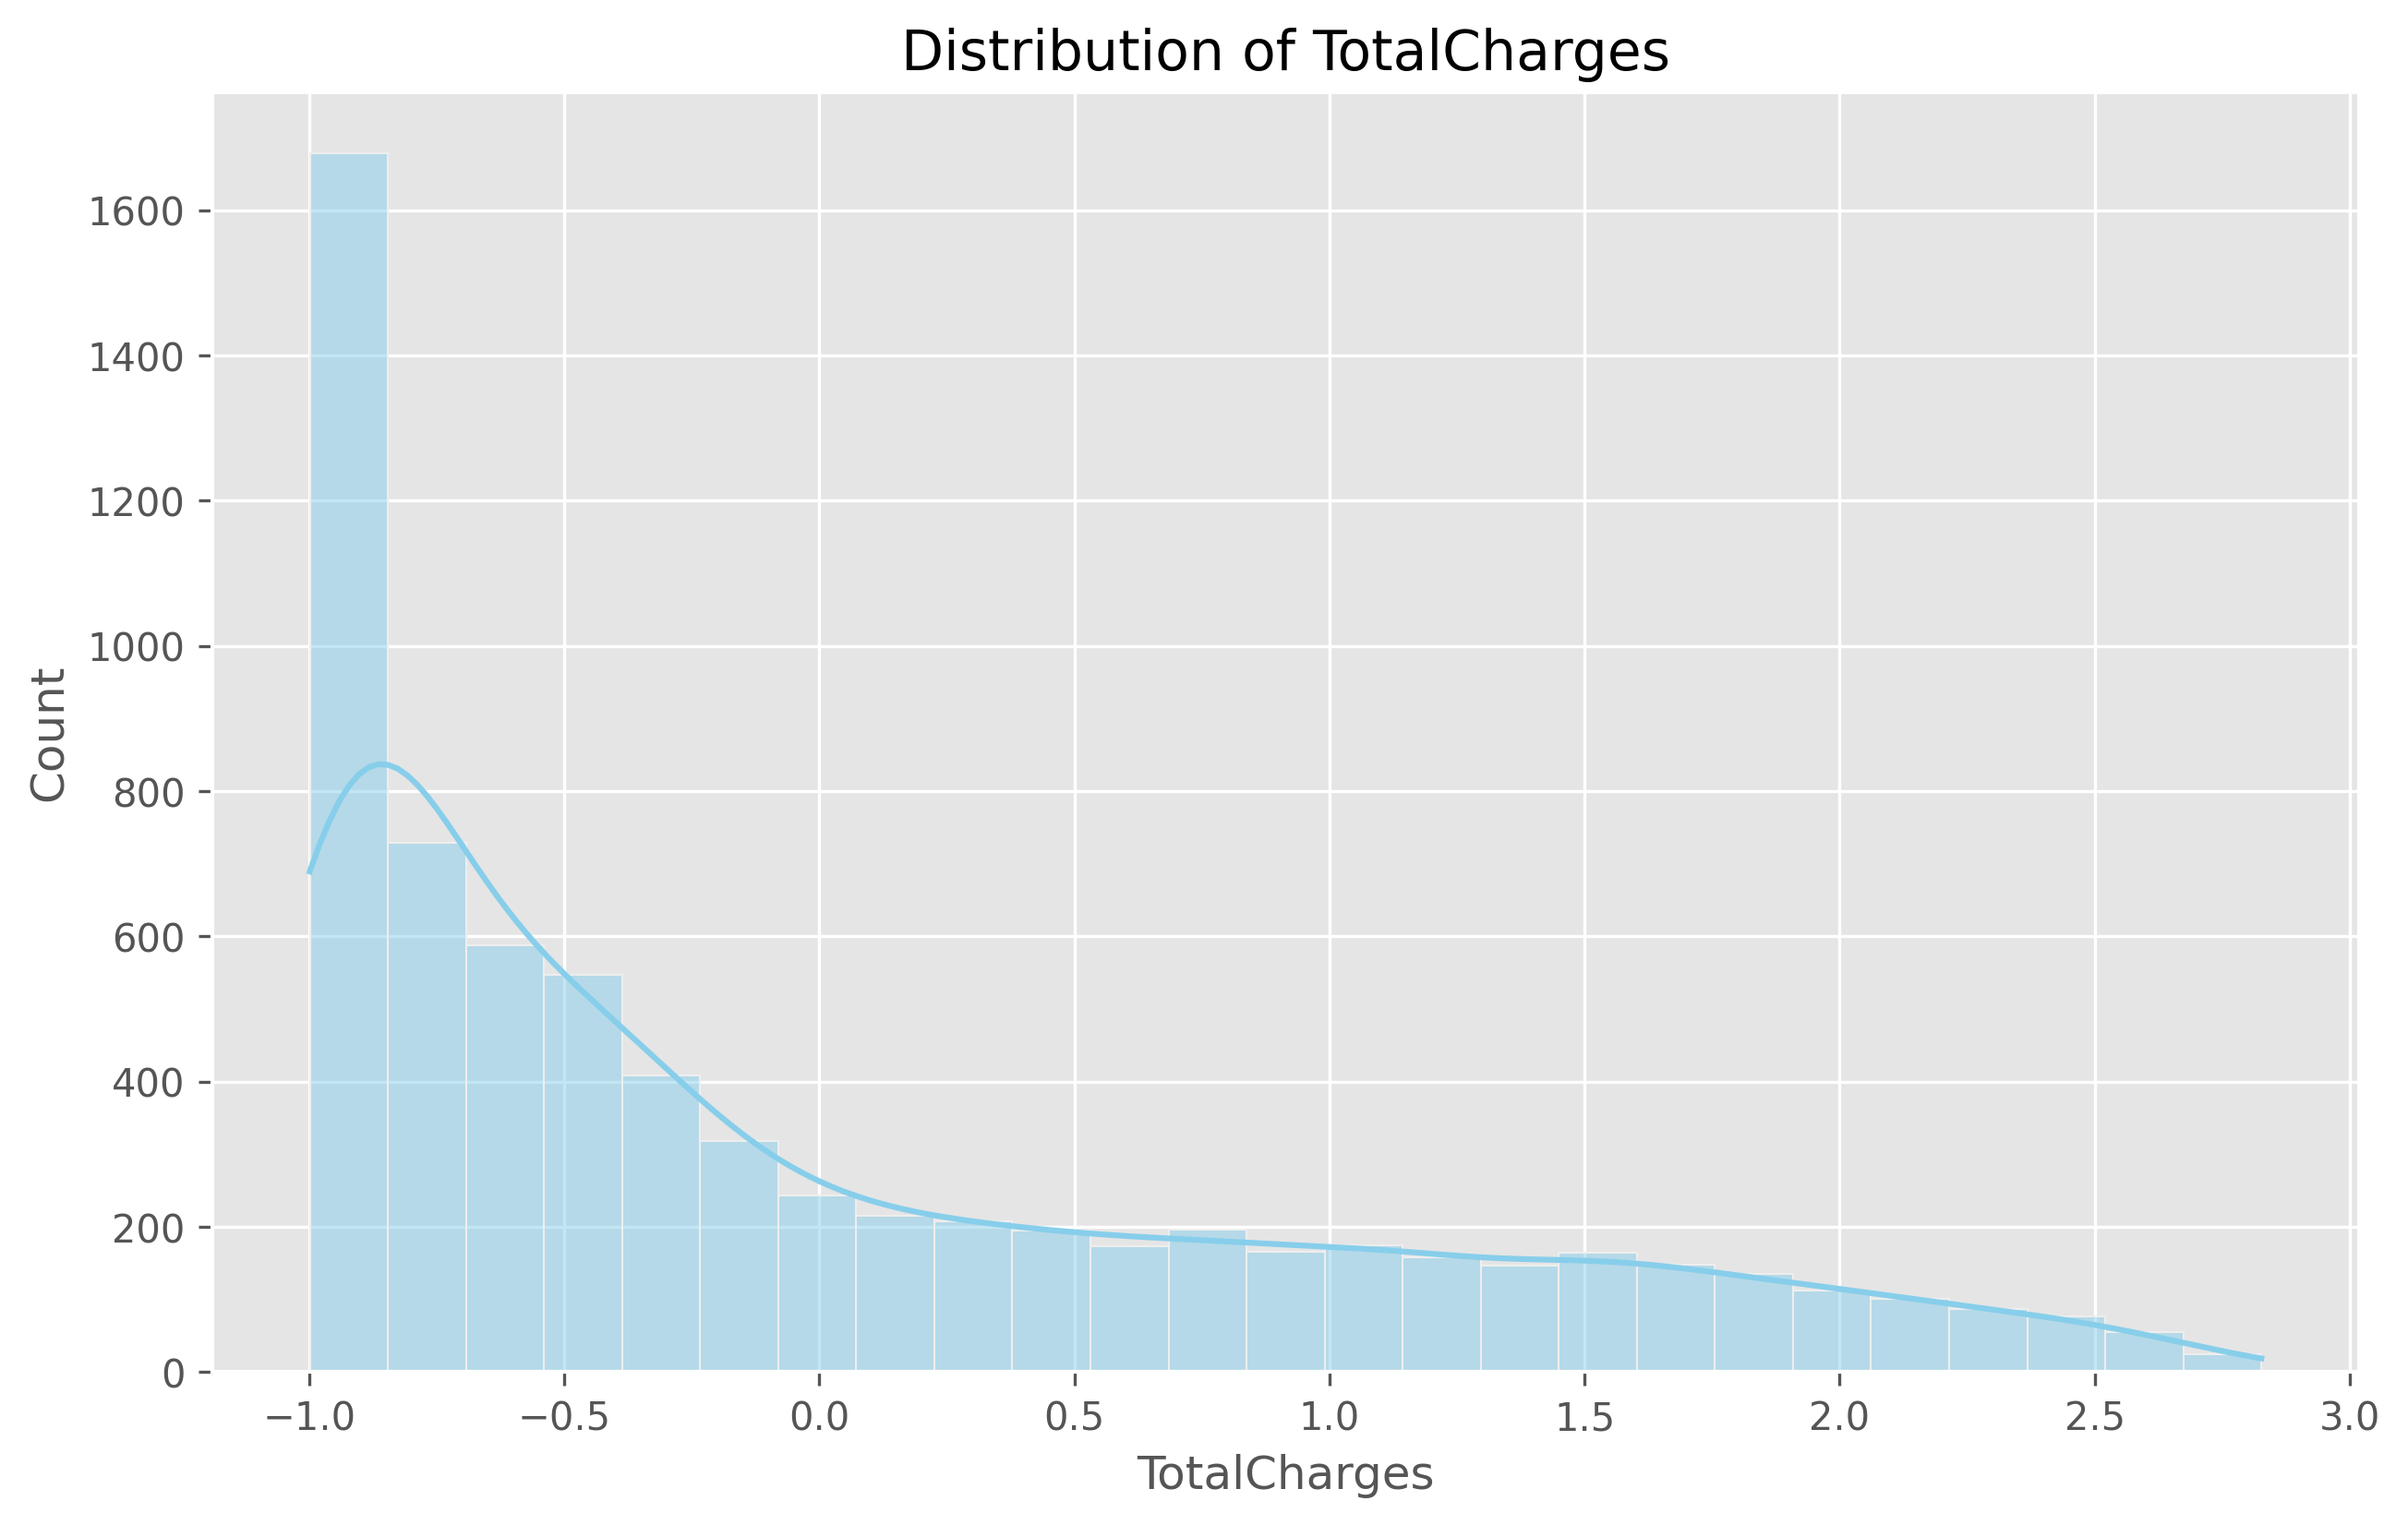

File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\churn_by_contract.png


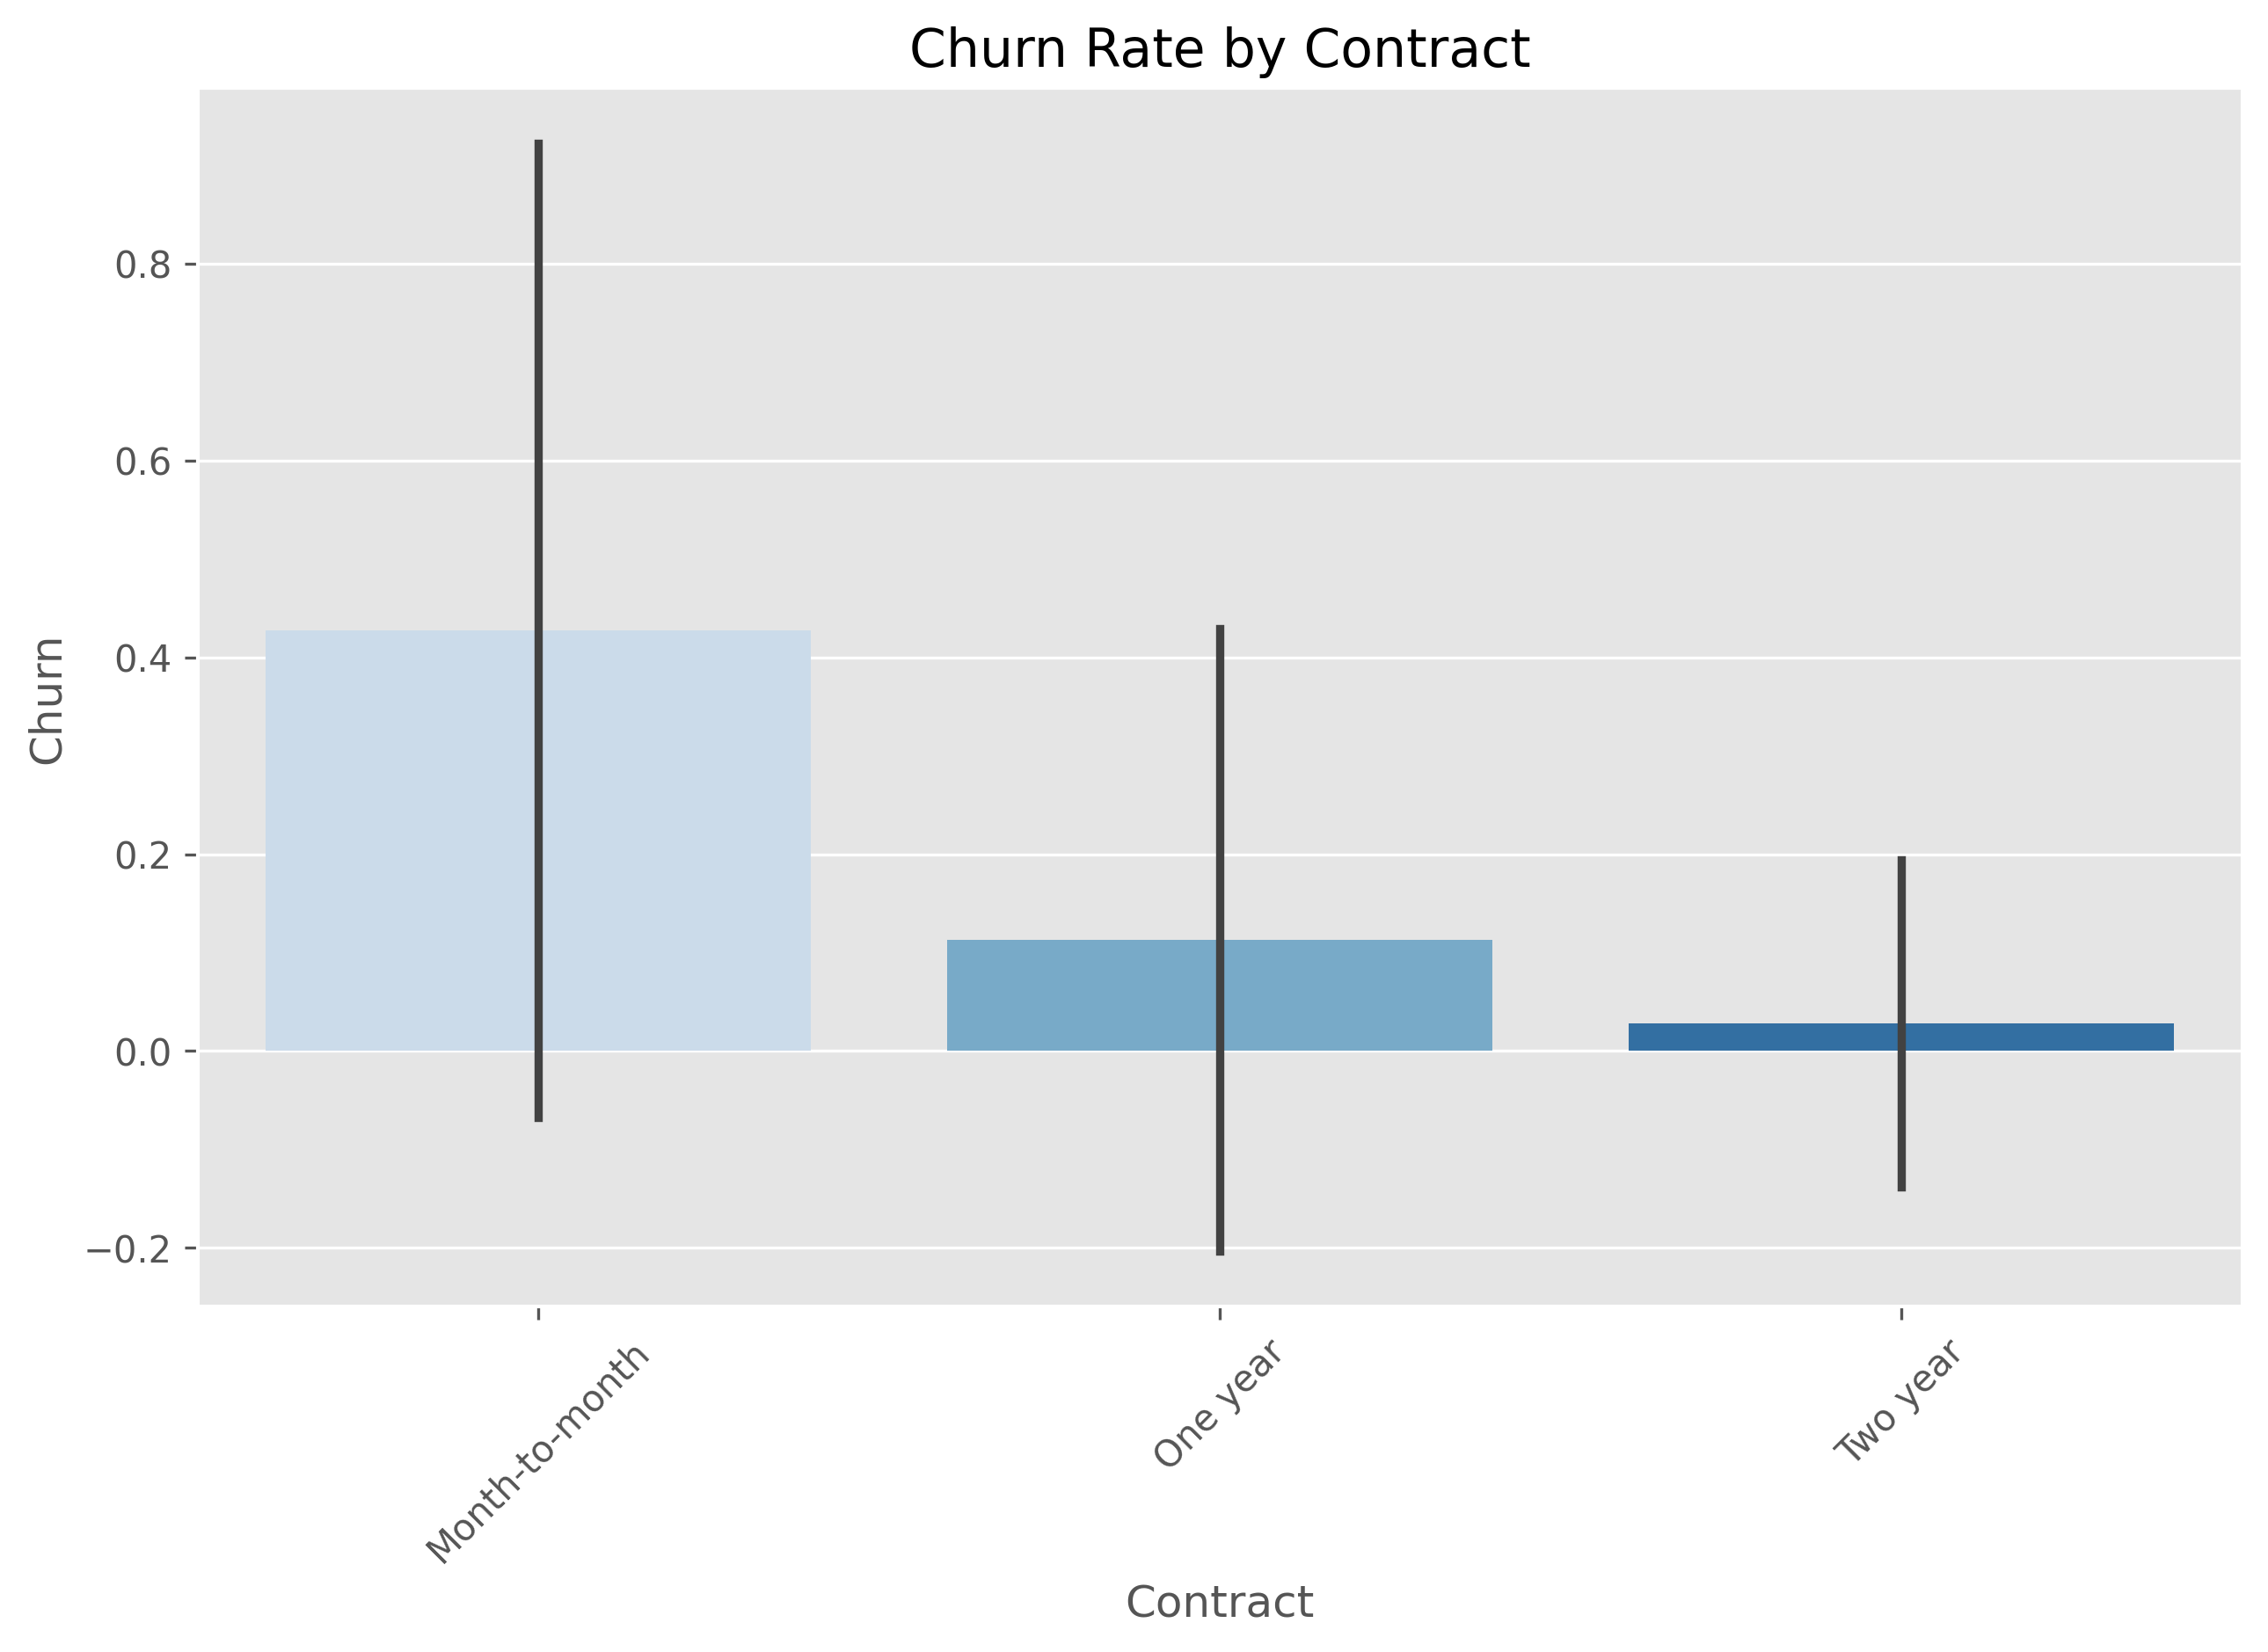

File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\churn_by_internetservice.png


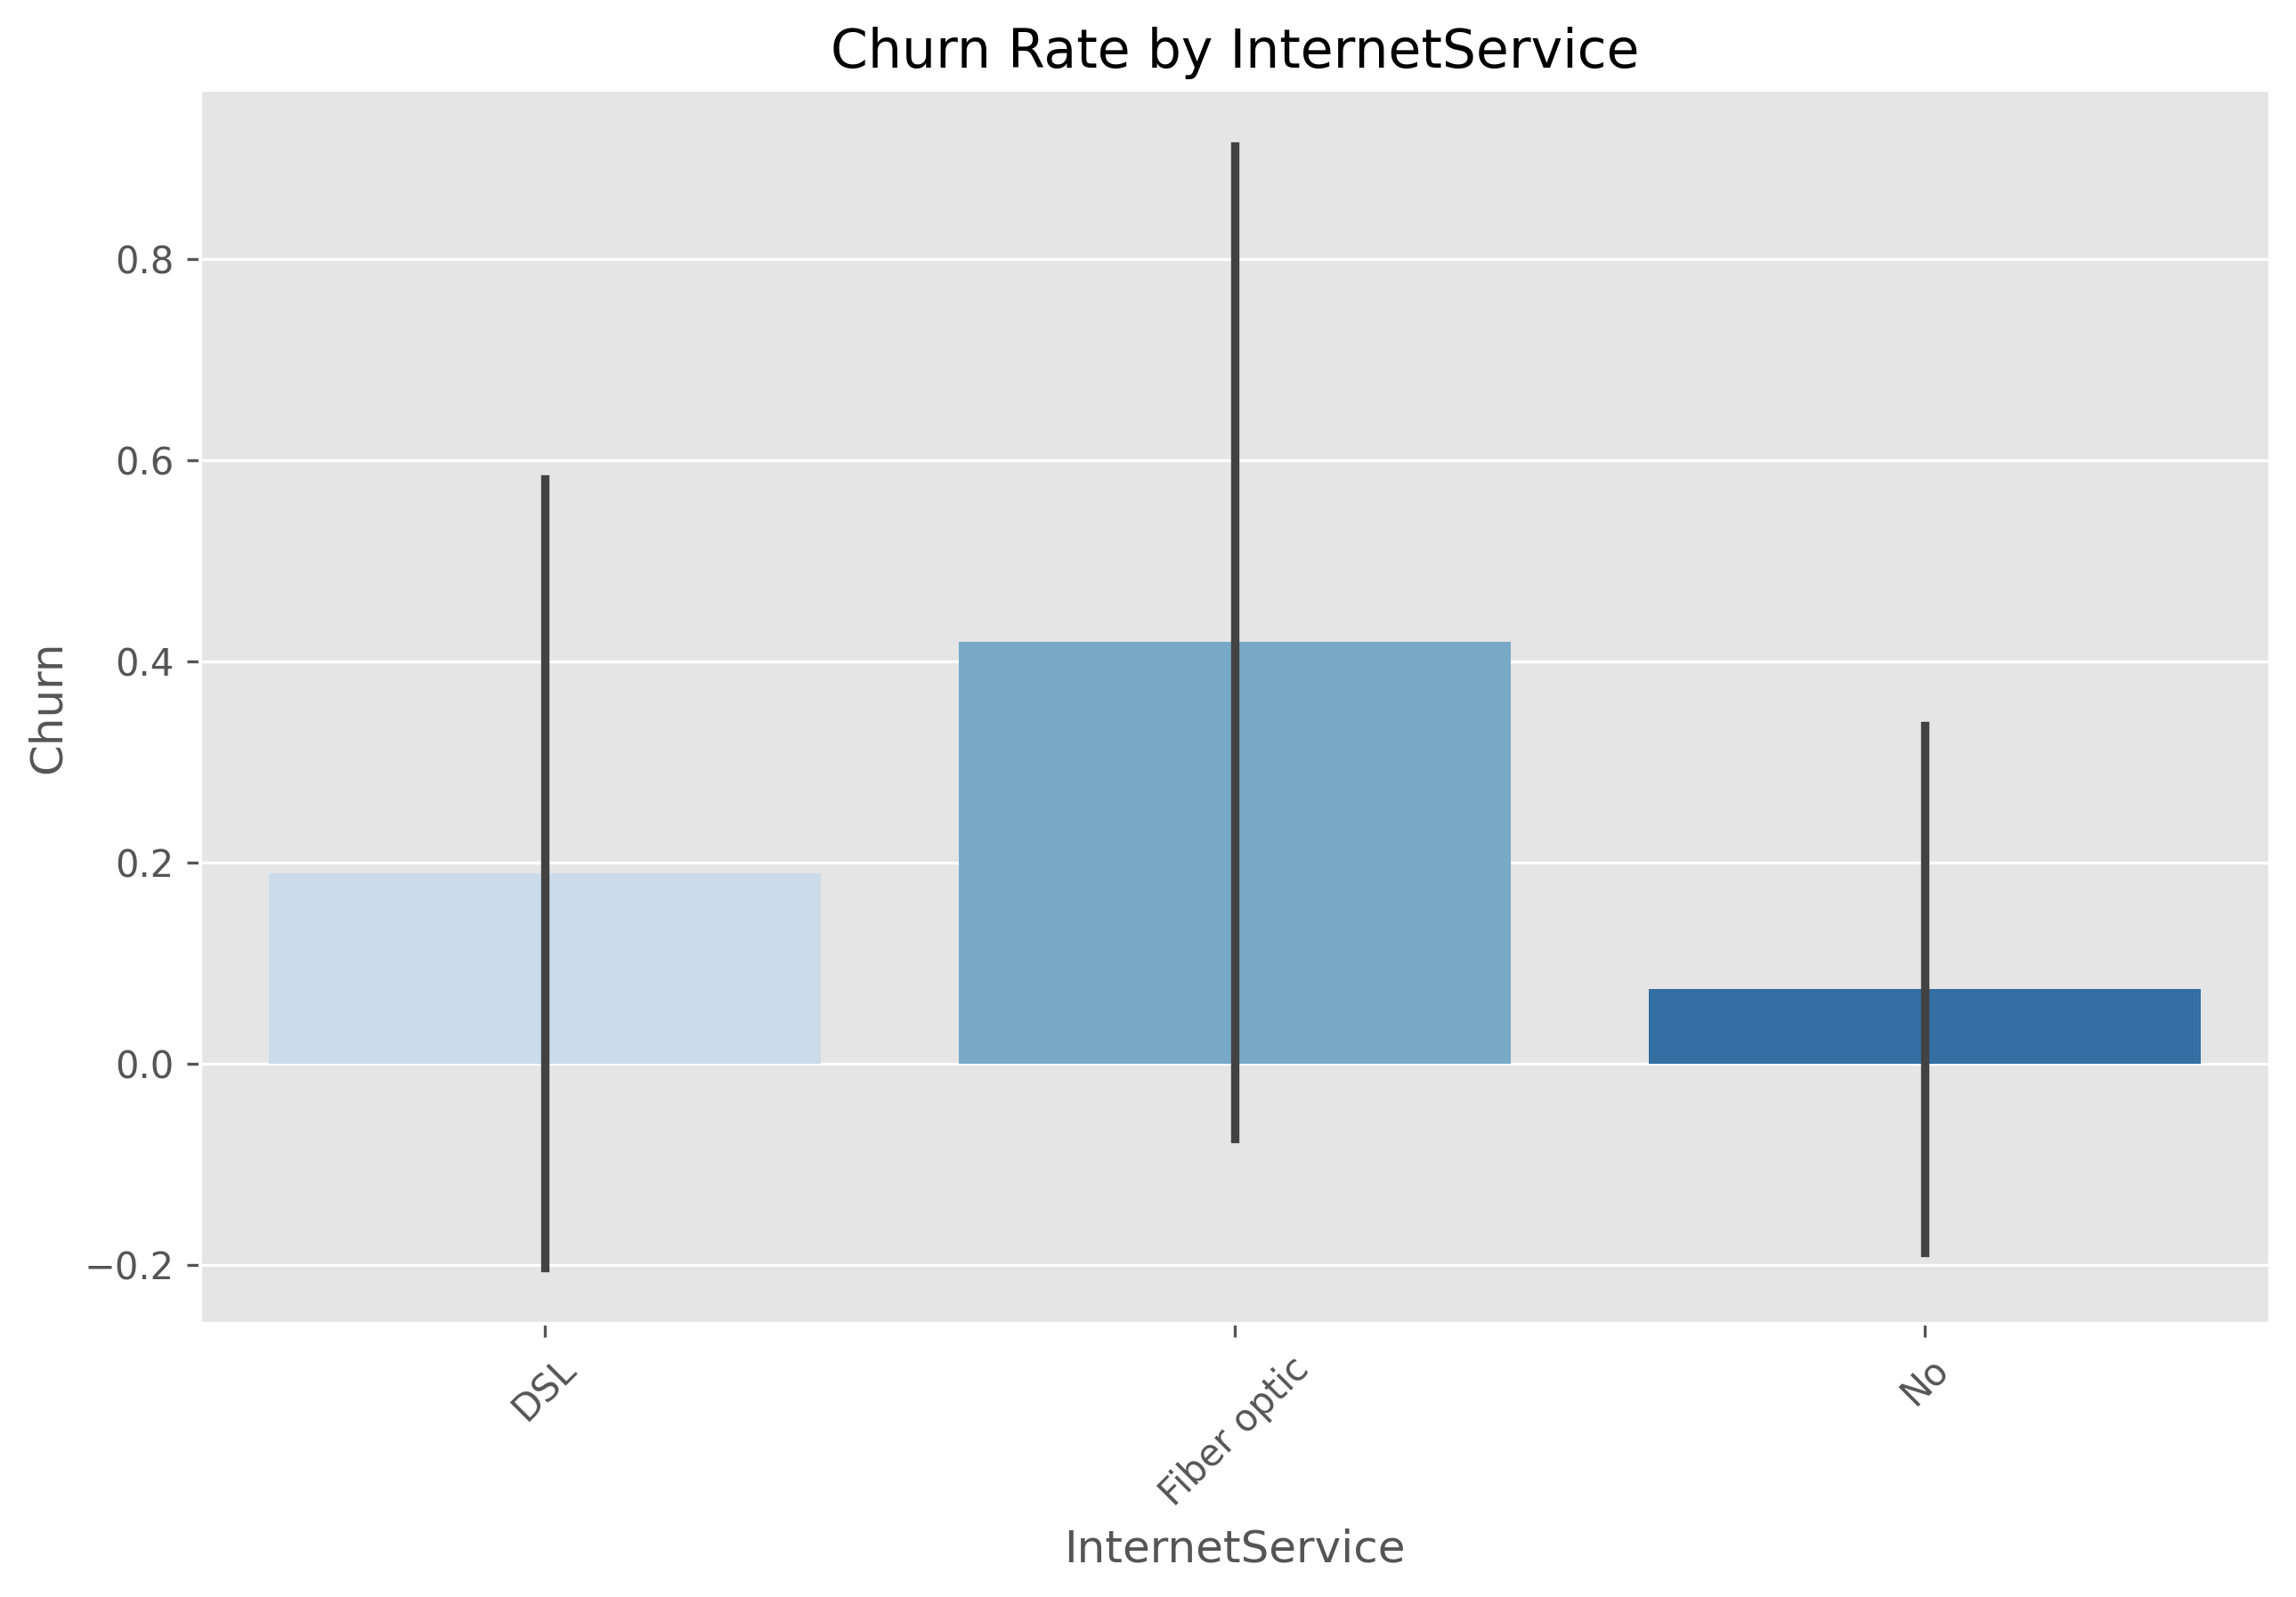

File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\churn_by_paymentmethod.png


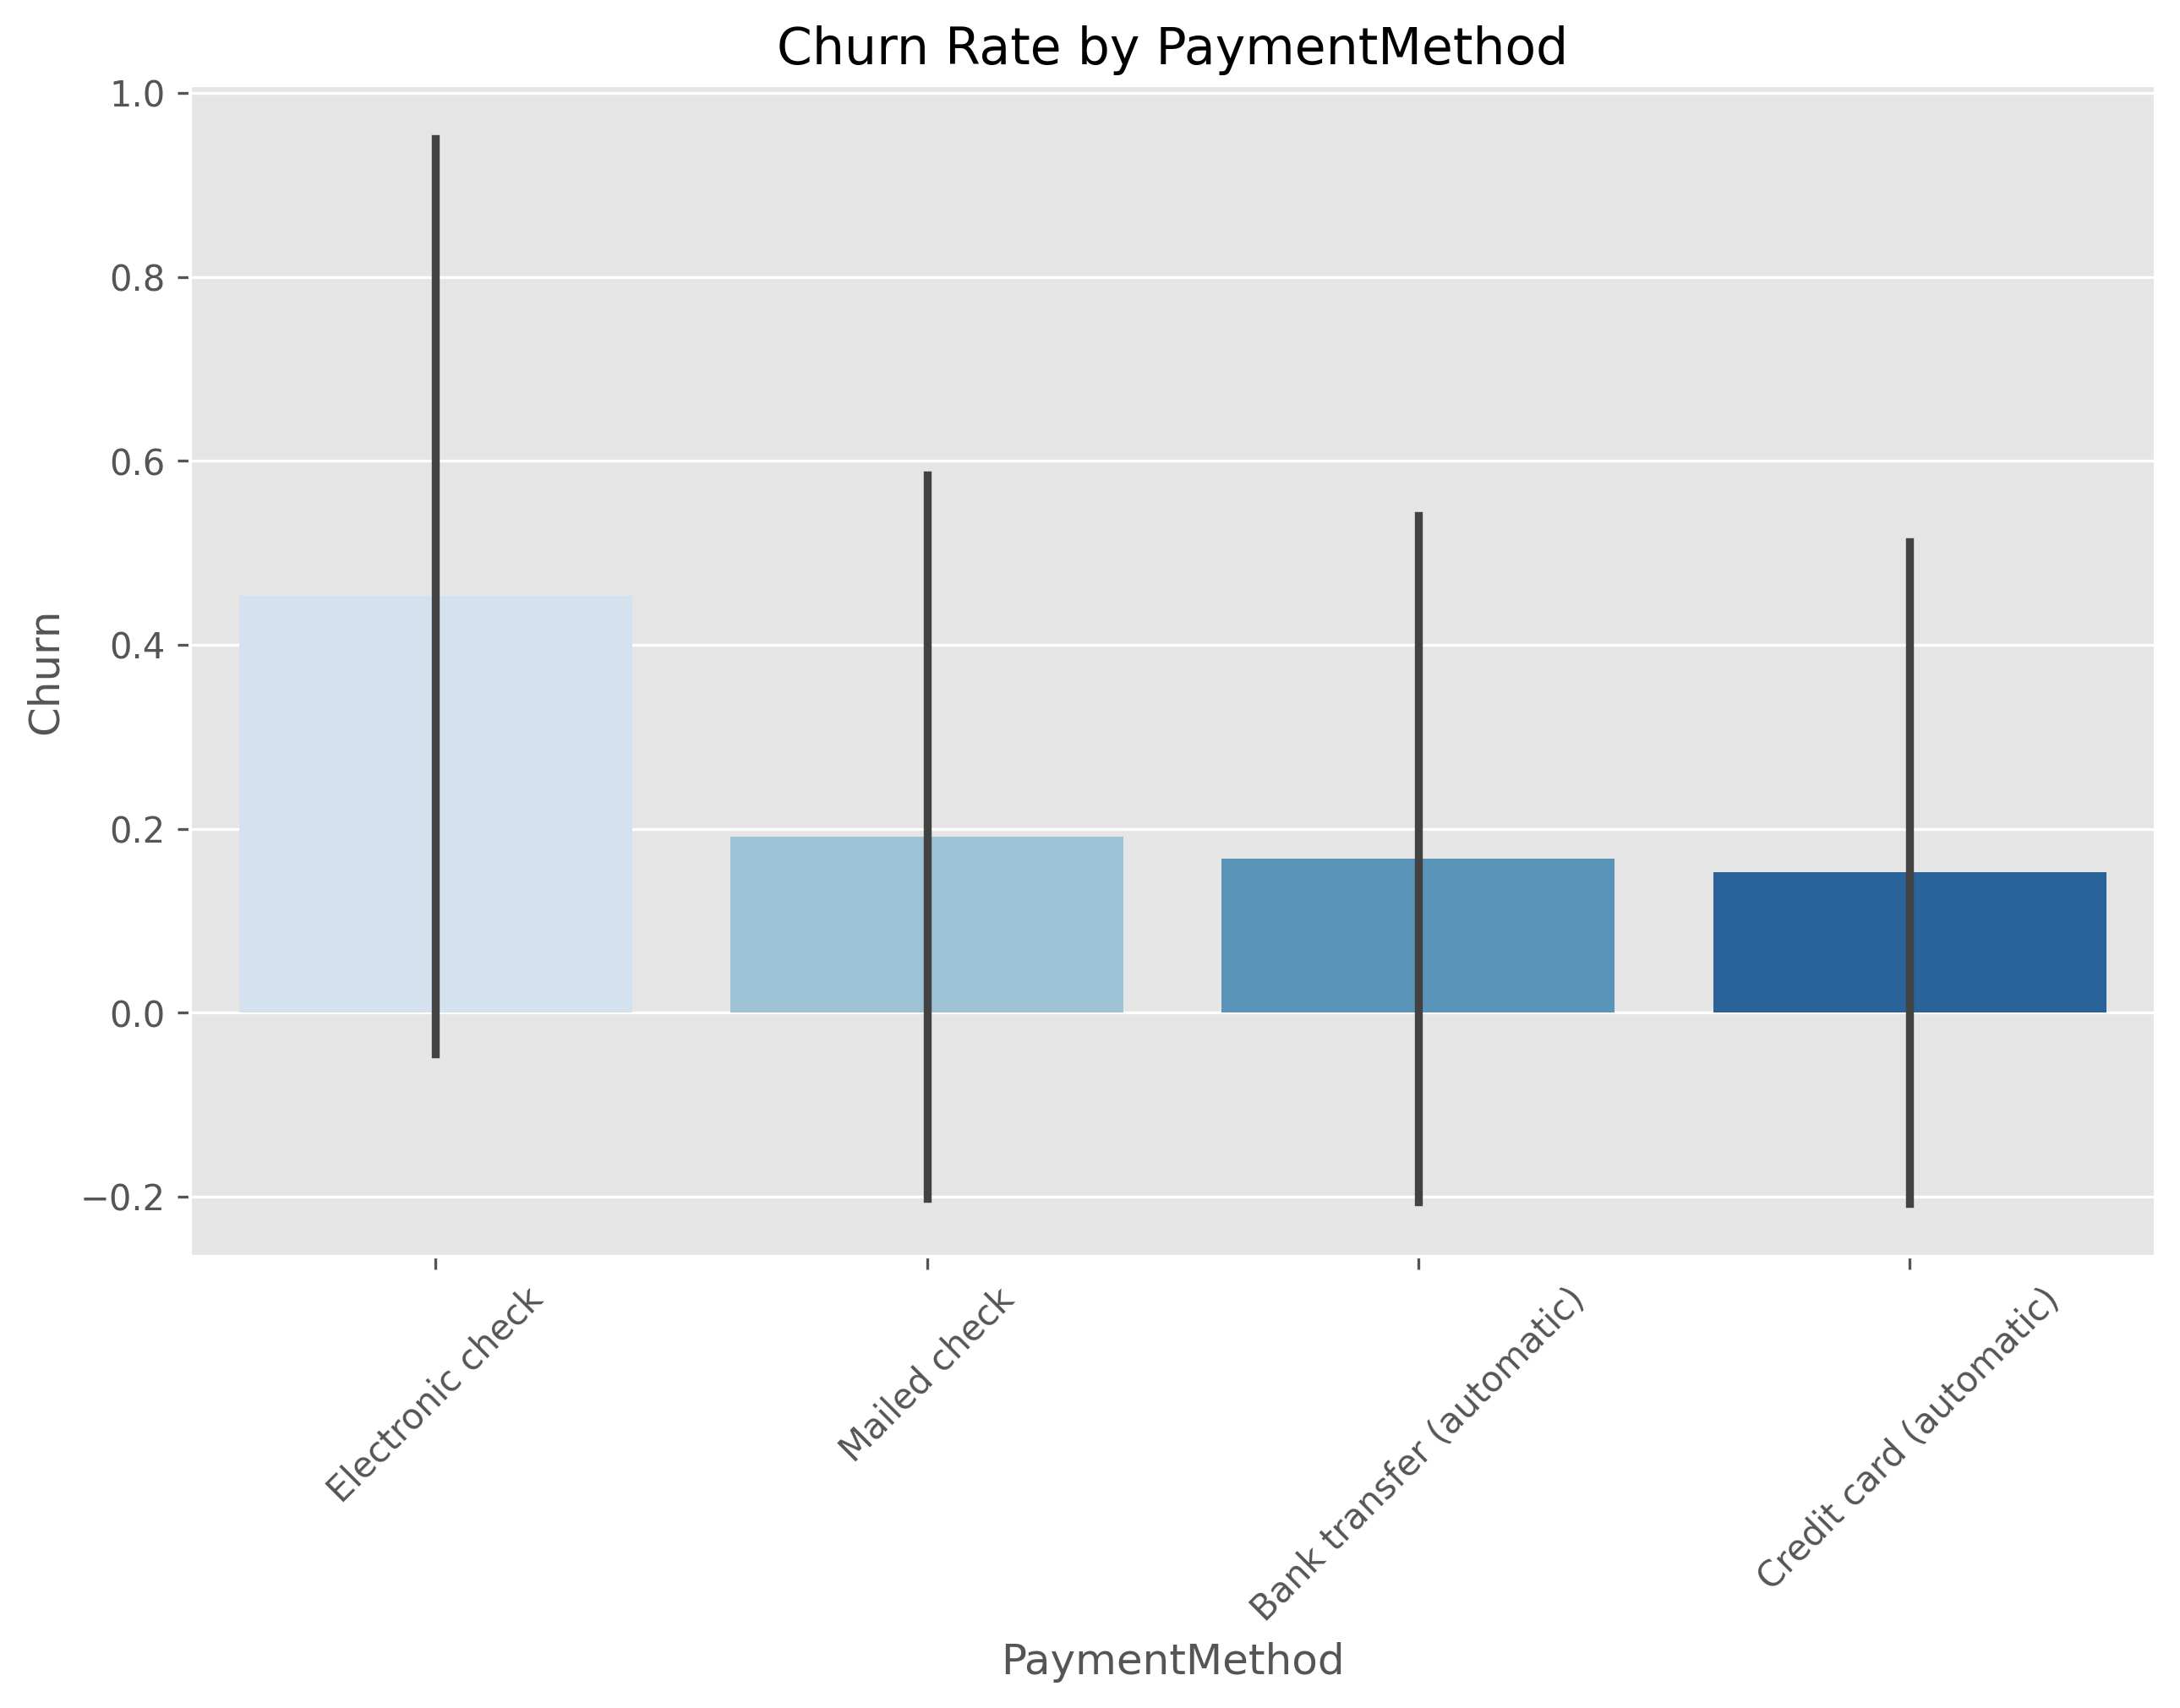

File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\churn_by_seniorcitizen.png


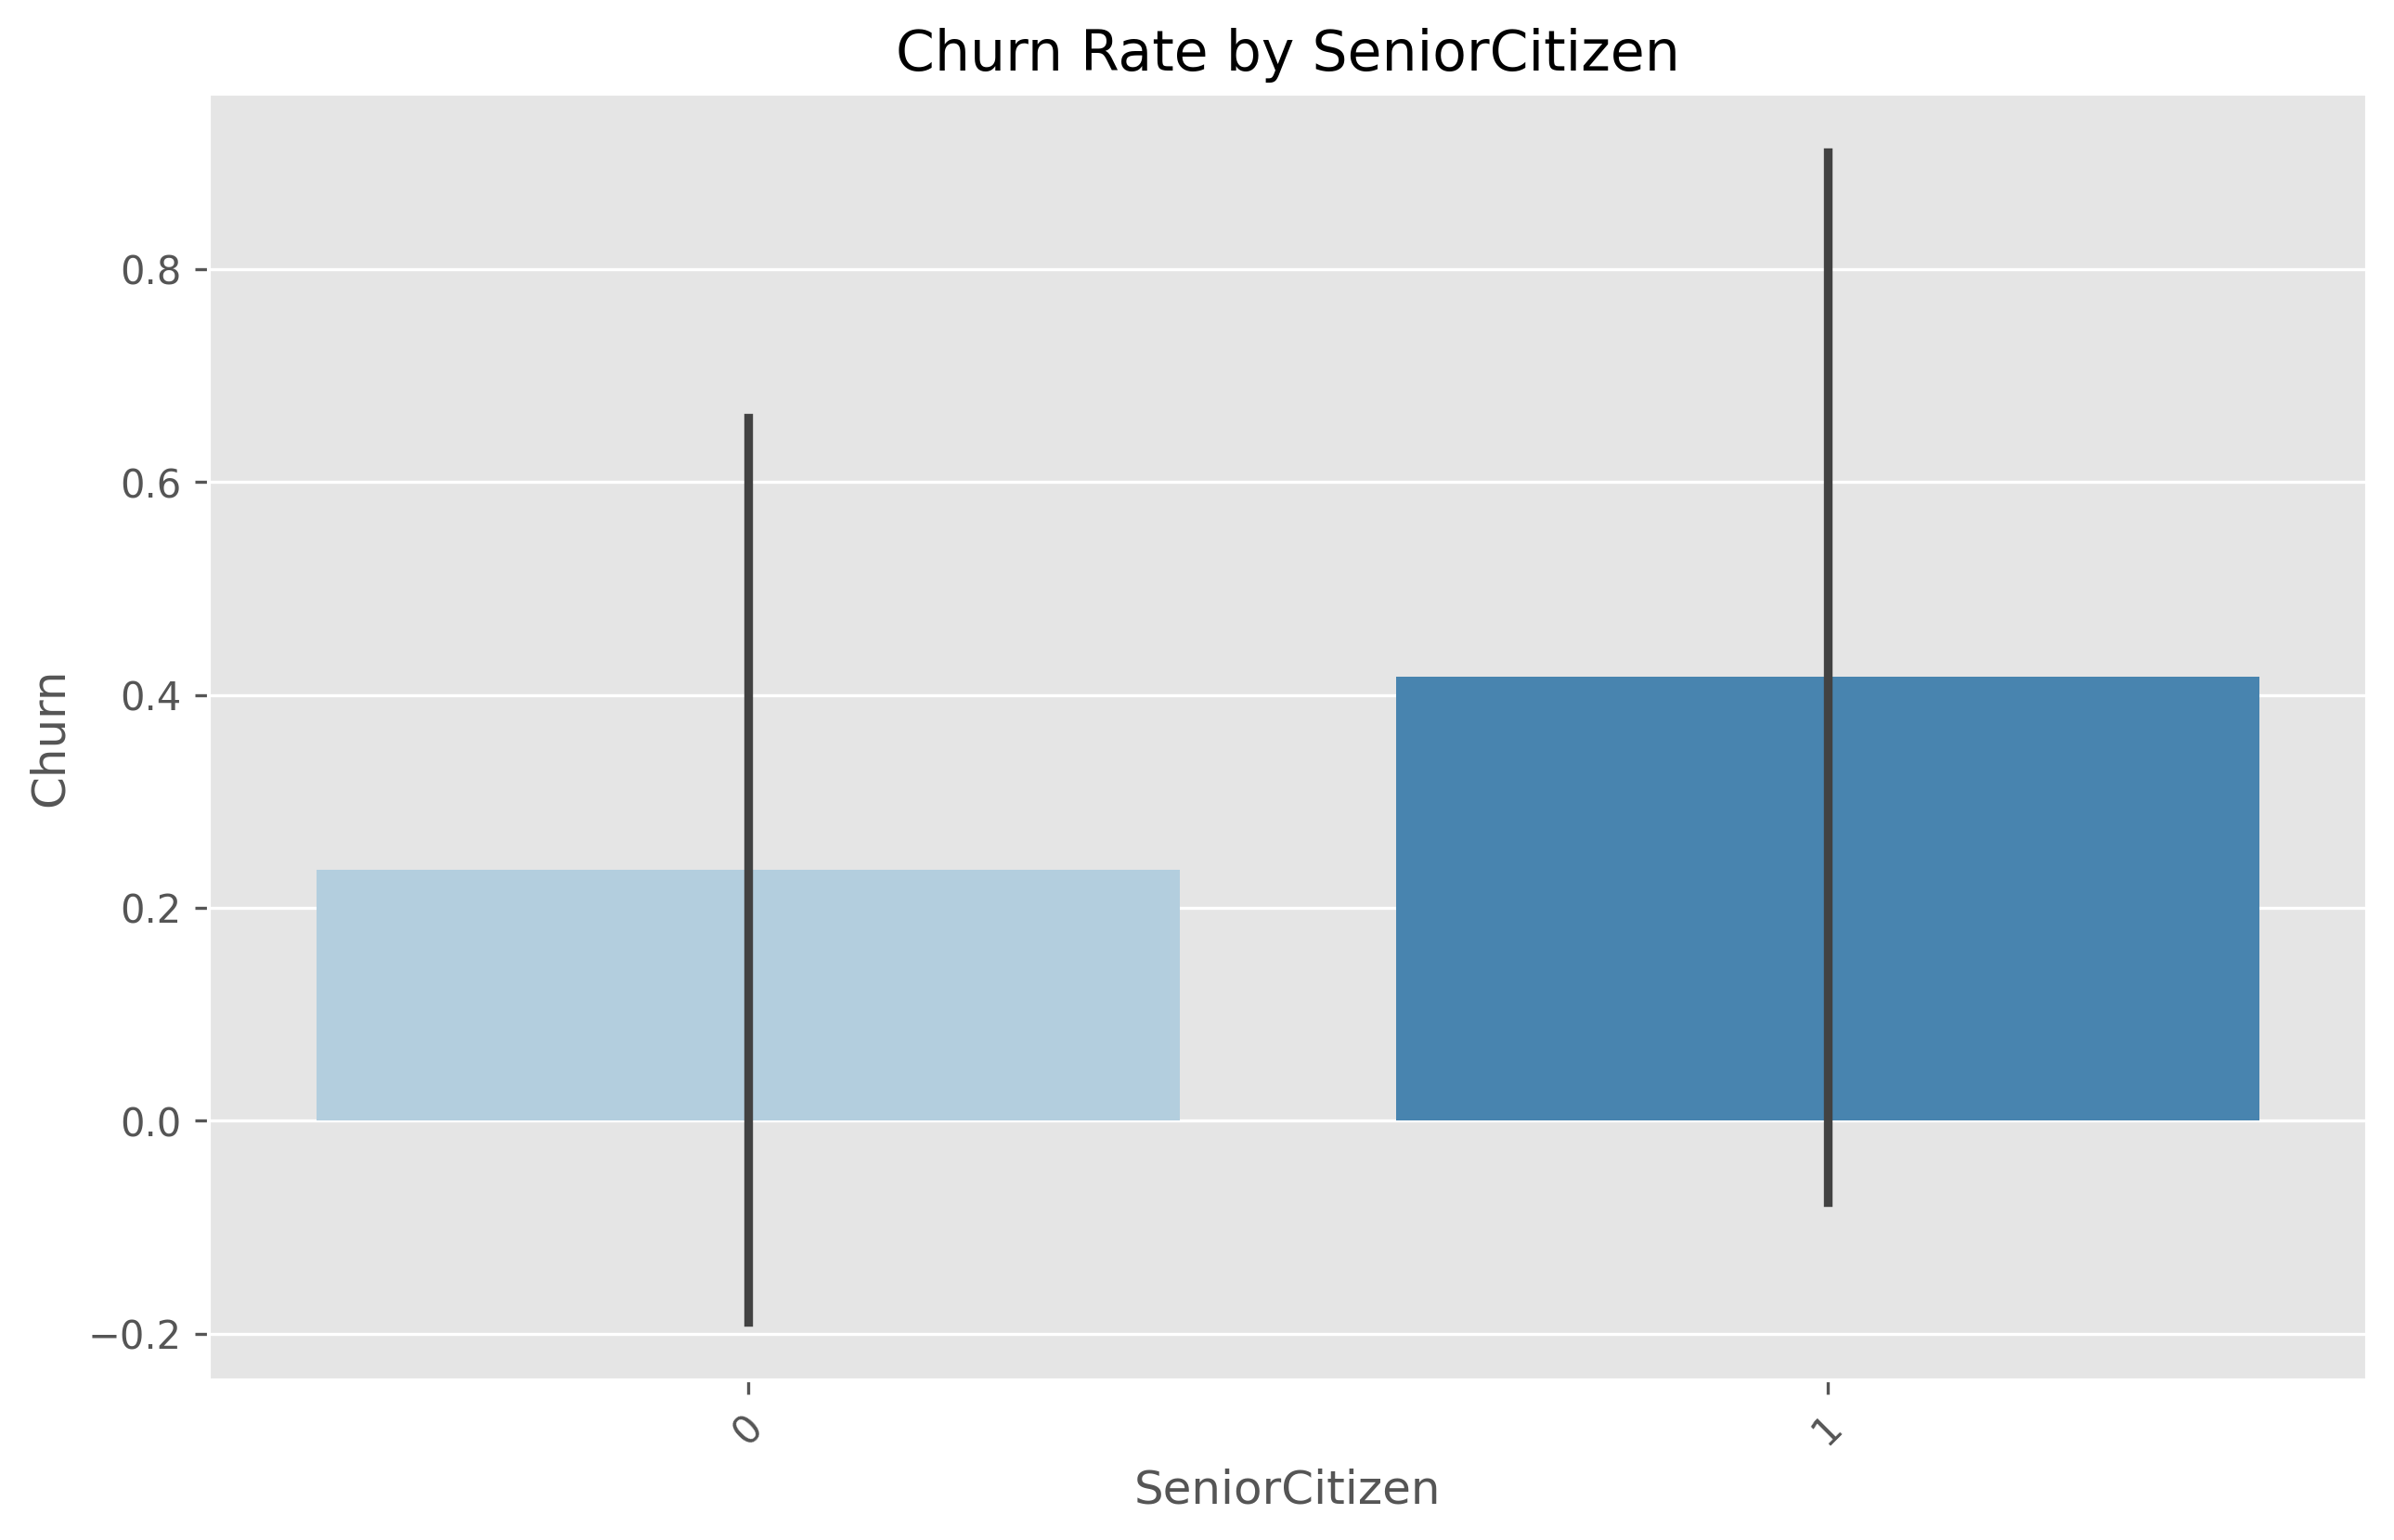

File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\churn_rates_by_categorical.csv


,Unnamed: 0,Contract,InternetService,PaymentMethod,SeniorCitizen
0,Month-to-month,42.709677,NaN,NaN,NaN
1,One year,11.269518,NaN,NaN,NaN
2,Two year,2.831858,NaN,NaN,NaN
3,DSL,NaN,18.959108,NaN,NaN
4,Fiber optic,NaN,41.892765,NaN,NaN


File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\correlation_heatmap.png


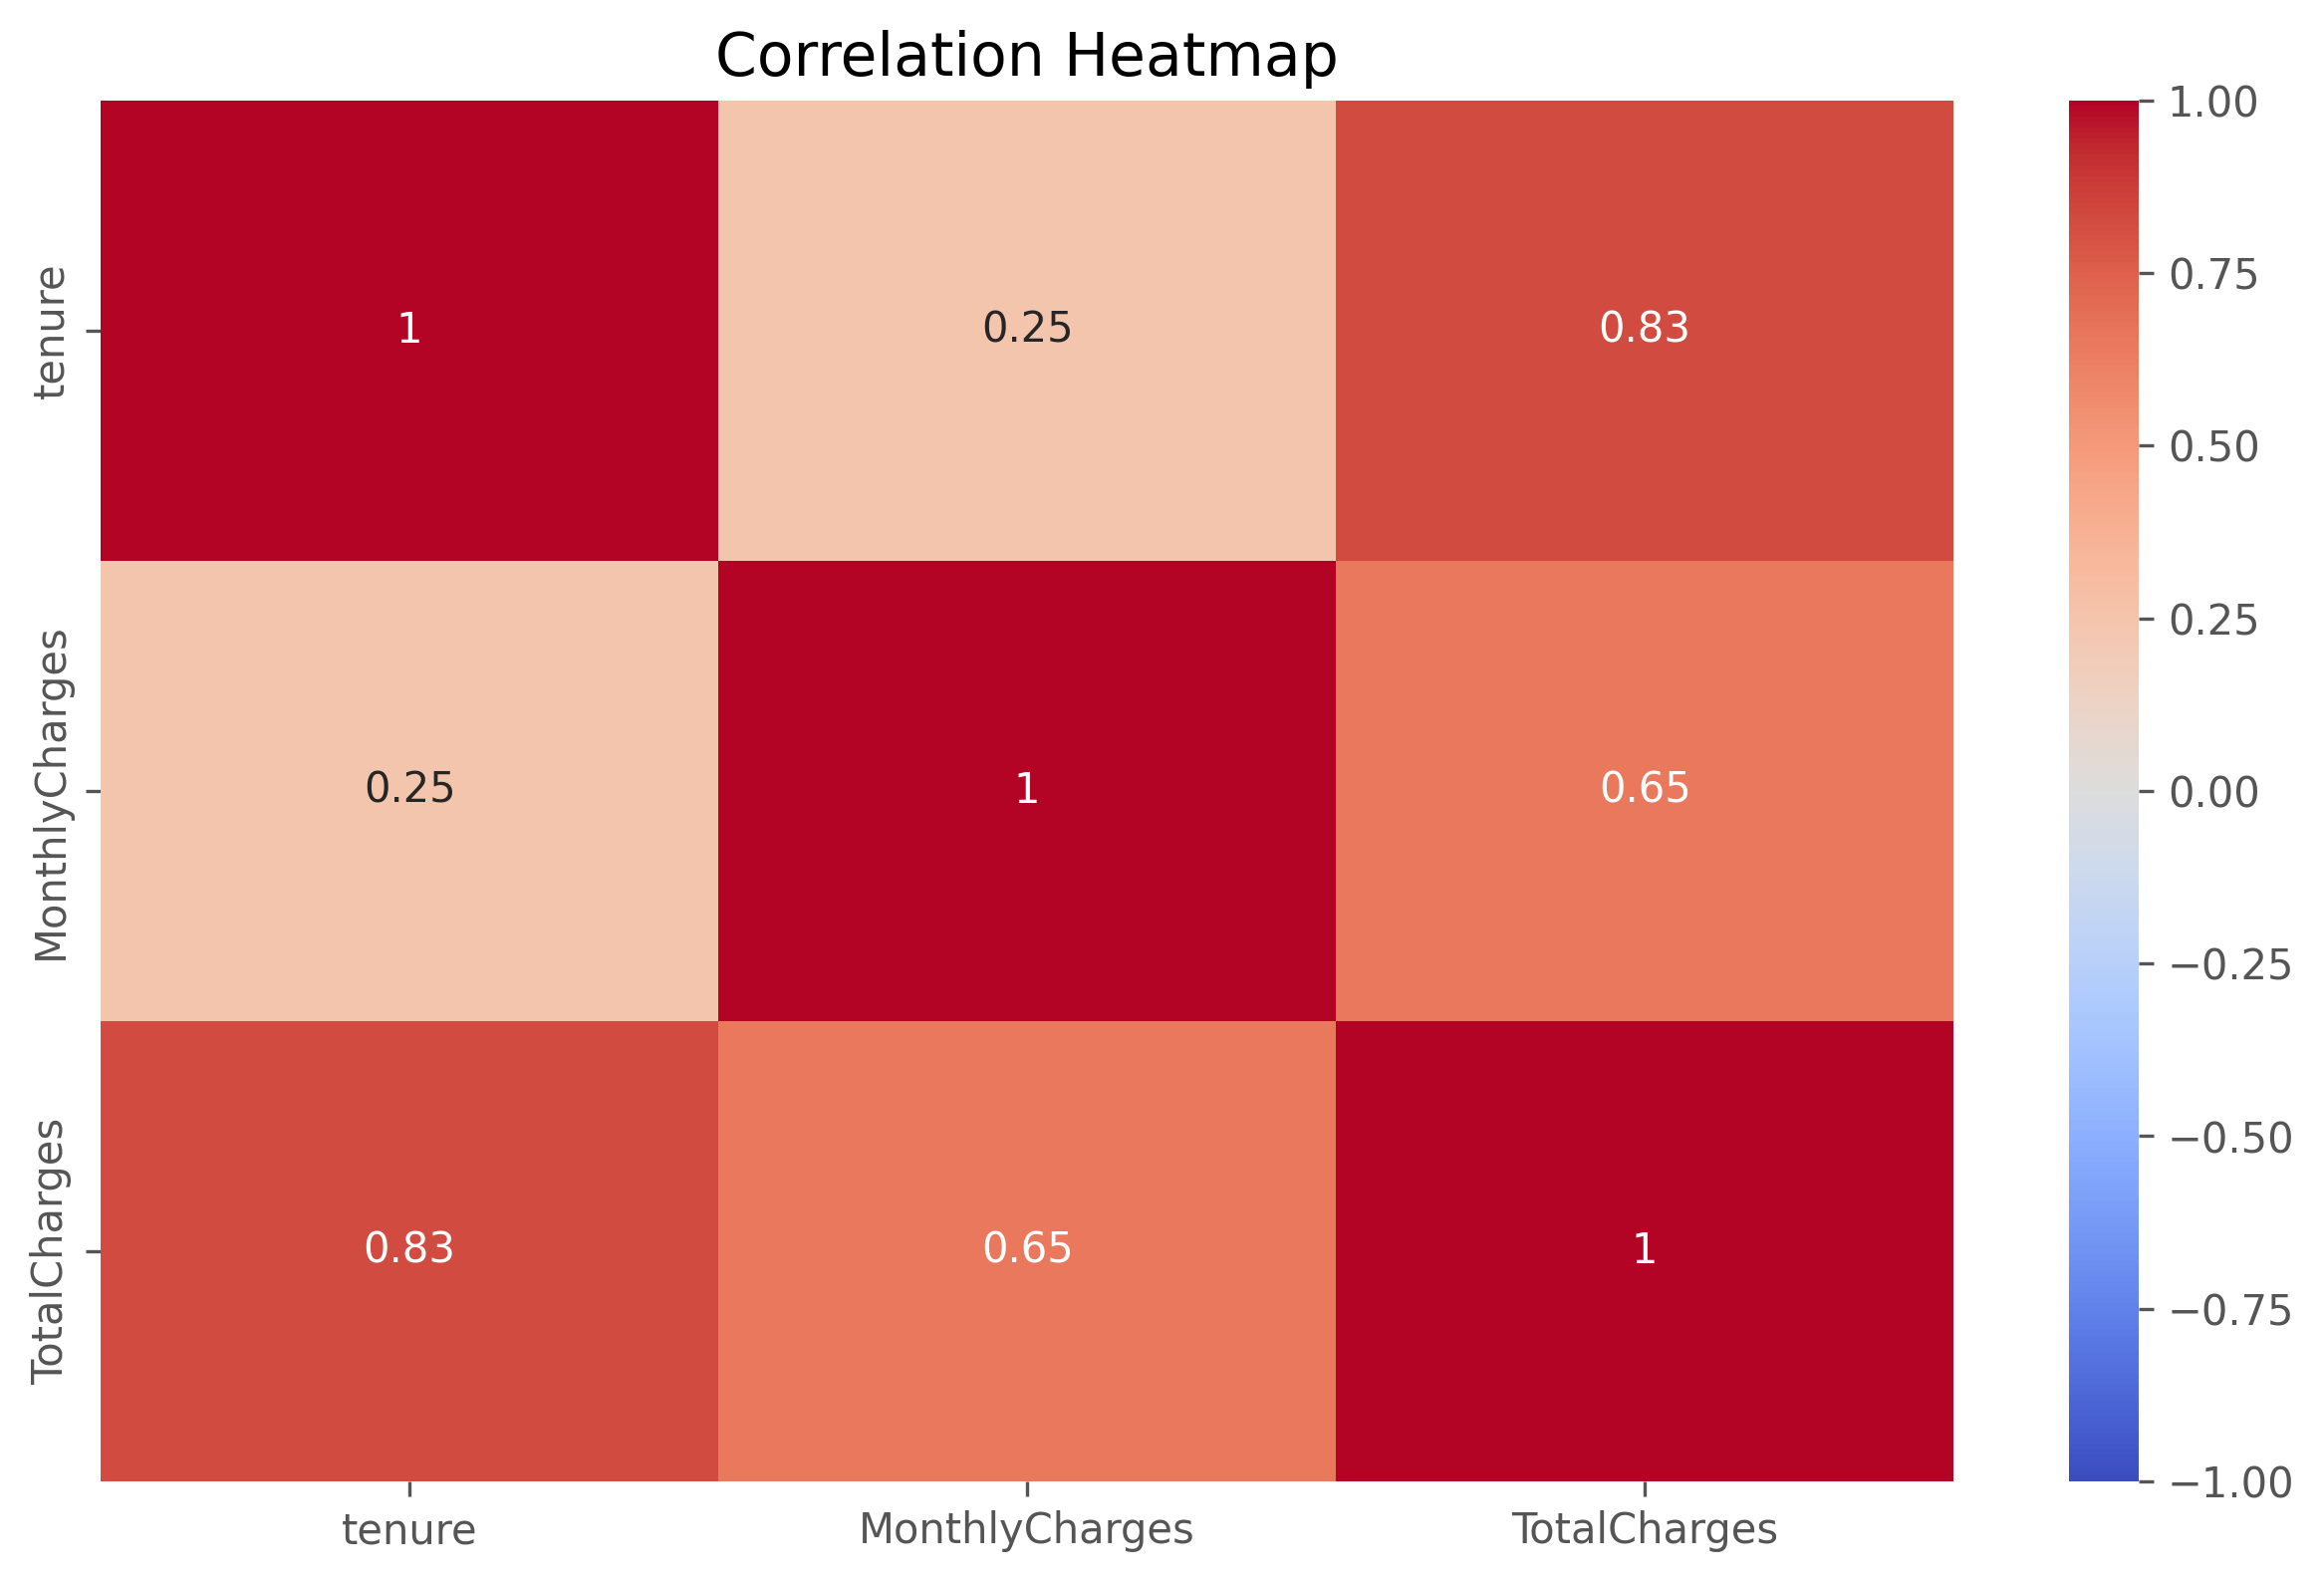

In [11]:
# Step 2: Exploratory Data Analysis
print("\nStep 2: Exploratory Data Analysis")
data = pd.read_csv(output_path)
original_data = pd.read_csv(input_path)
original_data['Churn'] = original_data['Churn'].map({'No': 0, 'Yes': 1})

# Summary statistics
numerical_summary = data[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()
numerical_summary_path = os.path.join(BASE_DIR, "numerical_summary.csv")
numerical_summary.to_csv(numerical_summary_path)
verify_and_display_file(numerical_summary_path)

# Churn rate
churn_rate = data['Churn'].mean() * 100
print(f"Overall Churn Rate: {churn_rate:.2f}%")

# Histograms
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    plt.figure()
    sns.histplot(data[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    hist_path = os.path.join(BASE_DIR, f"histogram_{col.lower()}.png")
    plt.savefig(hist_path, dpi=300, bbox_inches='tight')
    plt.close()
    verify_and_display_file(hist_path, is_image=True)

# Churn rates by categorical features
categorical_features = ['Contract', 'InternetService', 'PaymentMethod', 'SeniorCitizen']
churn_by_categorical = {}
for feature in categorical_features:
    churn_rates = original_data.groupby(feature)['Churn'].mean() * 100
    churn_by_categorical[feature] = churn_rates
    plt.figure()
    sns.barplot(x=feature, y='Churn', hue=feature, data=original_data, errorbar='sd', palette='Blues', legend=False)
    plt.title(f'Churn Rate by {feature}')
    plt.xticks(rotation=45)
    churn_plot_path = os.path.join(BASE_DIR, f"churn_by_{feature.lower()}.png")
    plt.savefig(churn_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    verify_and_display_file(churn_plot_path, is_image=True)

churn_rates_df = pd.concat([pd.DataFrame({feature: churn_by_categorical[feature]}) 
                           for feature in categorical_features], axis=1)
churn_rates_path = os.path.join(BASE_DIR, "churn_rates_by_categorical.csv")
churn_rates_df.to_csv(churn_rates_path)
verify_and_display_file(churn_rates_path)

# Correlation heatmap
plt.figure()
correlation_matrix = data[['tenure', 'MonthlyCharges', 'TotalCharges']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
heatmap_path = os.path.join(BASE_DIR, "correlation_heatmap.png")
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
plt.close()
verify_and_display_file(heatmap_path, is_image=True)


Step 3: Principal Component Analysis
File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\pca_pve.csv


,Principal Component,PVE,Cumulative PVE
0,PC1,0.392108,0.392108
1,PC2,0.186830,0.578938
2,PC3,0.060986,0.639924
3,PC4,0.035136,0.675060
4,PC5,0.033161,0.708221


File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\scree_plot.png


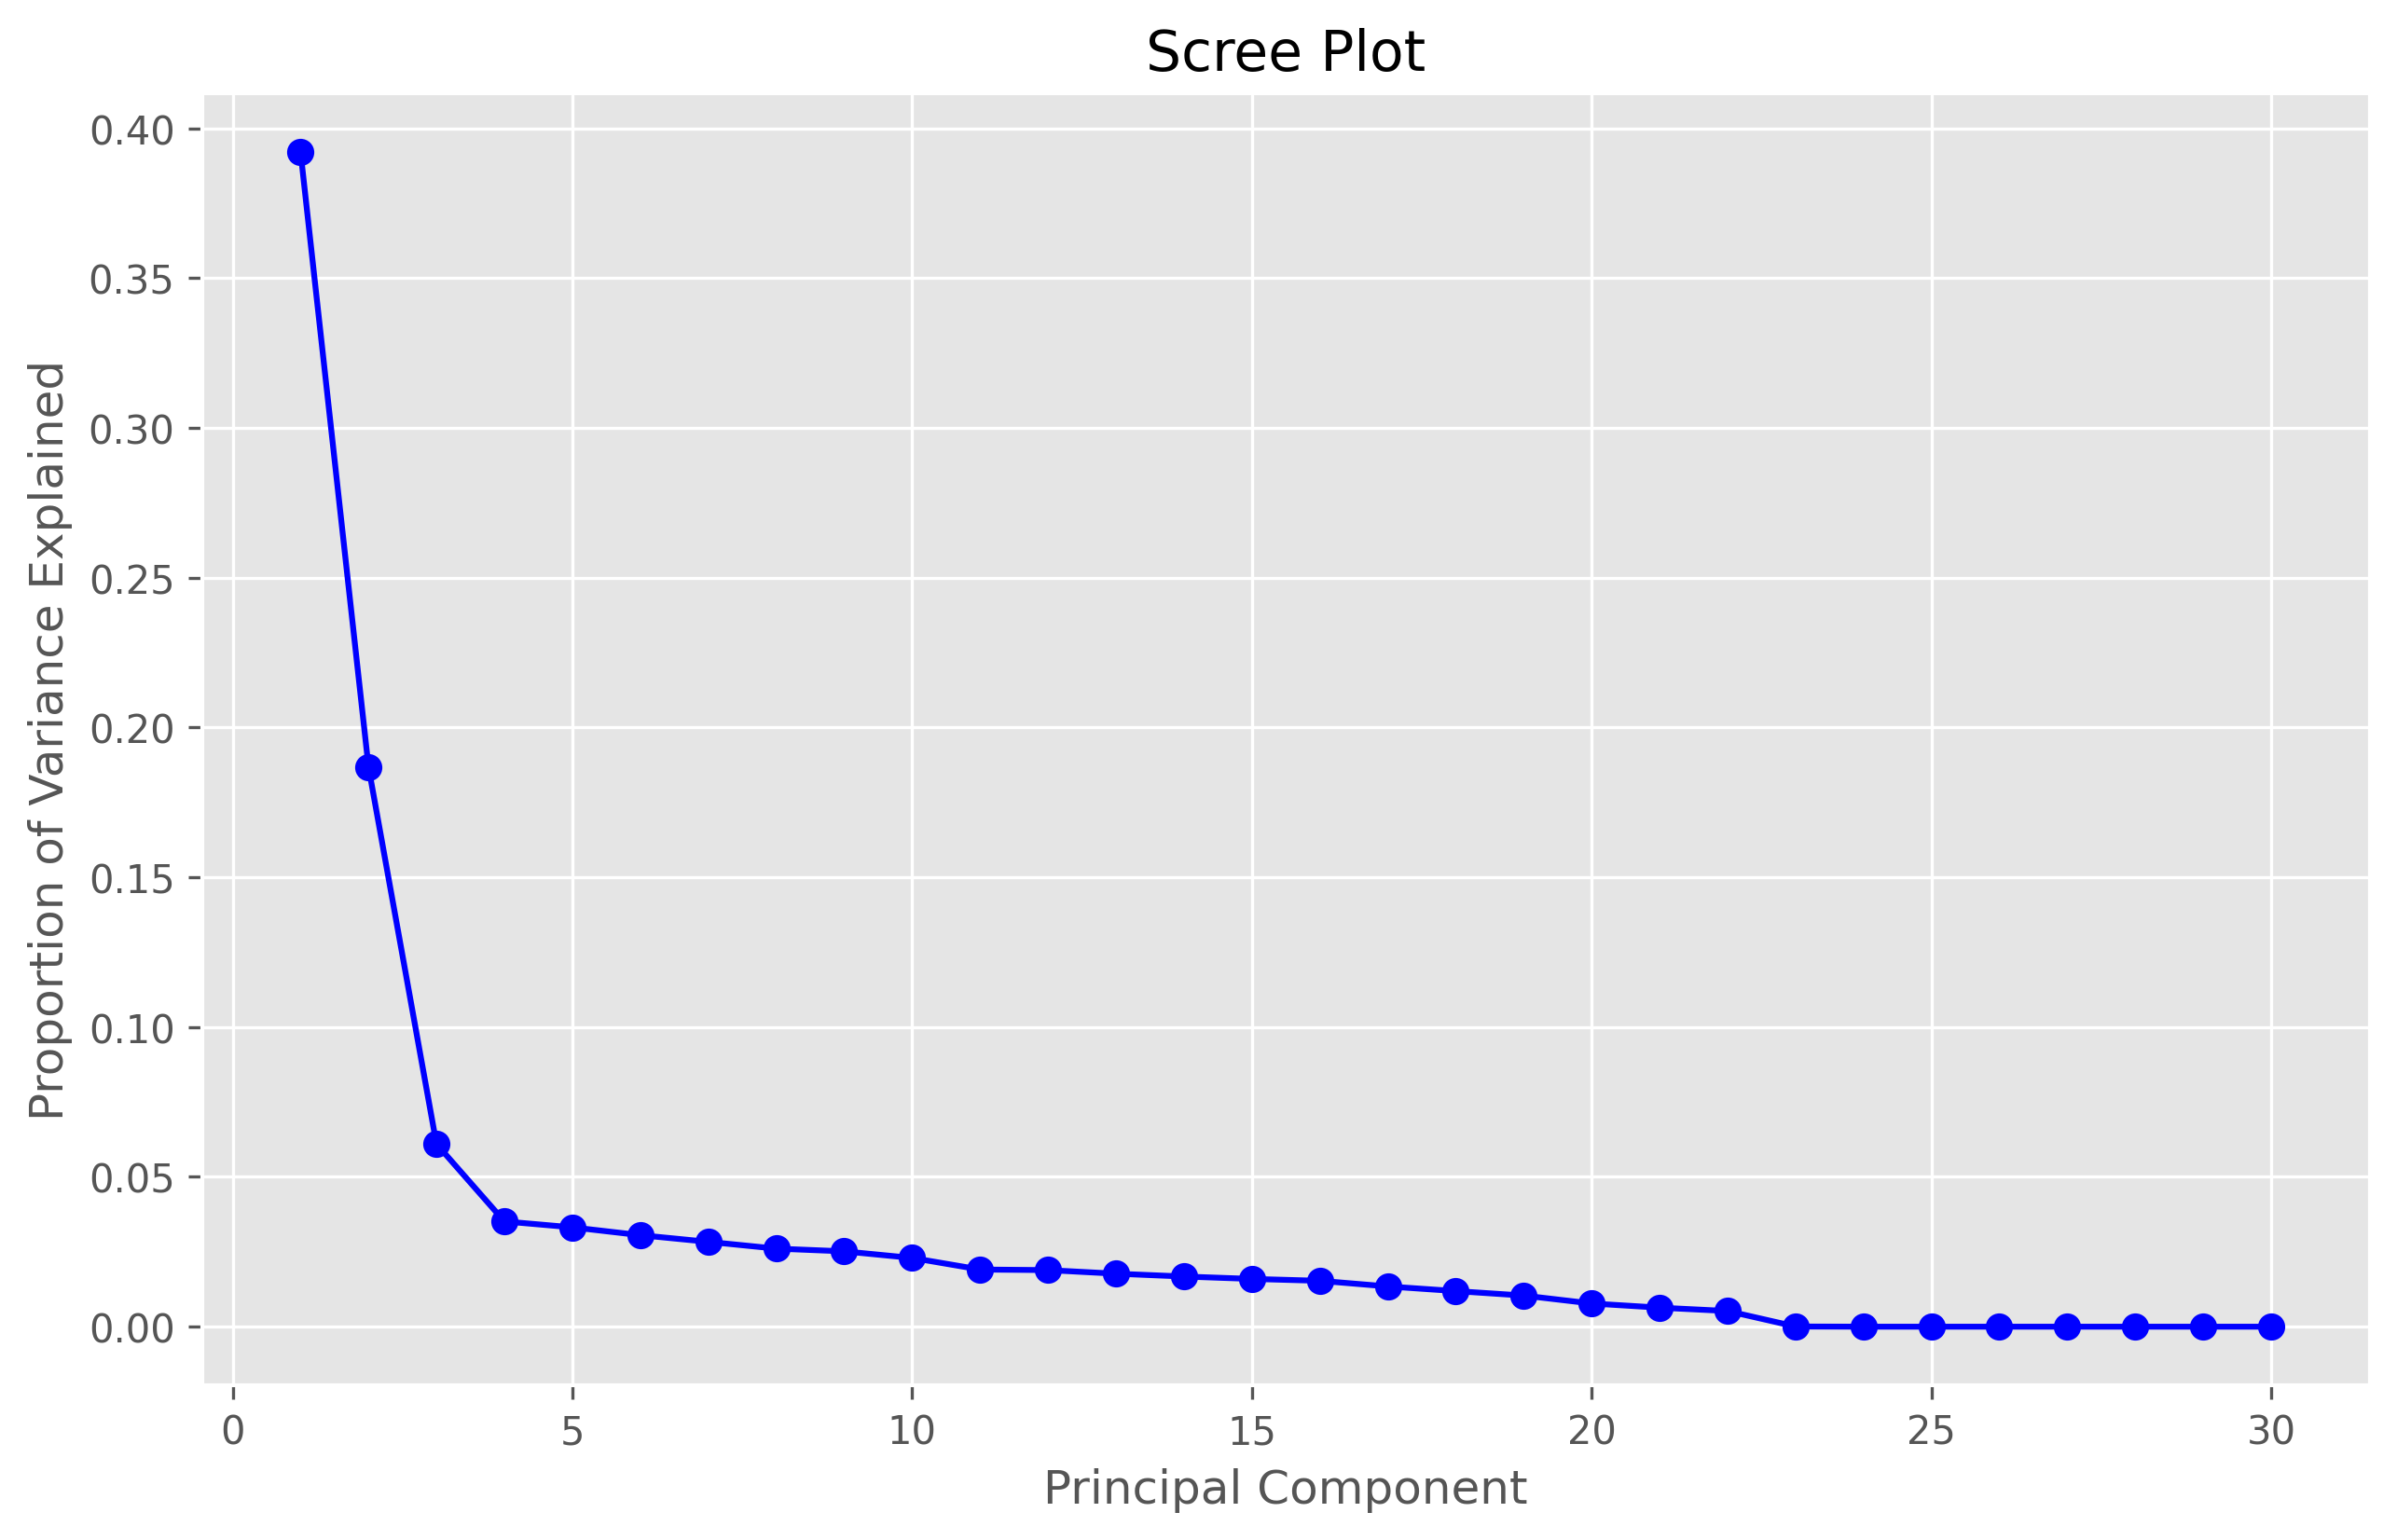

File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\pca_biplot.png


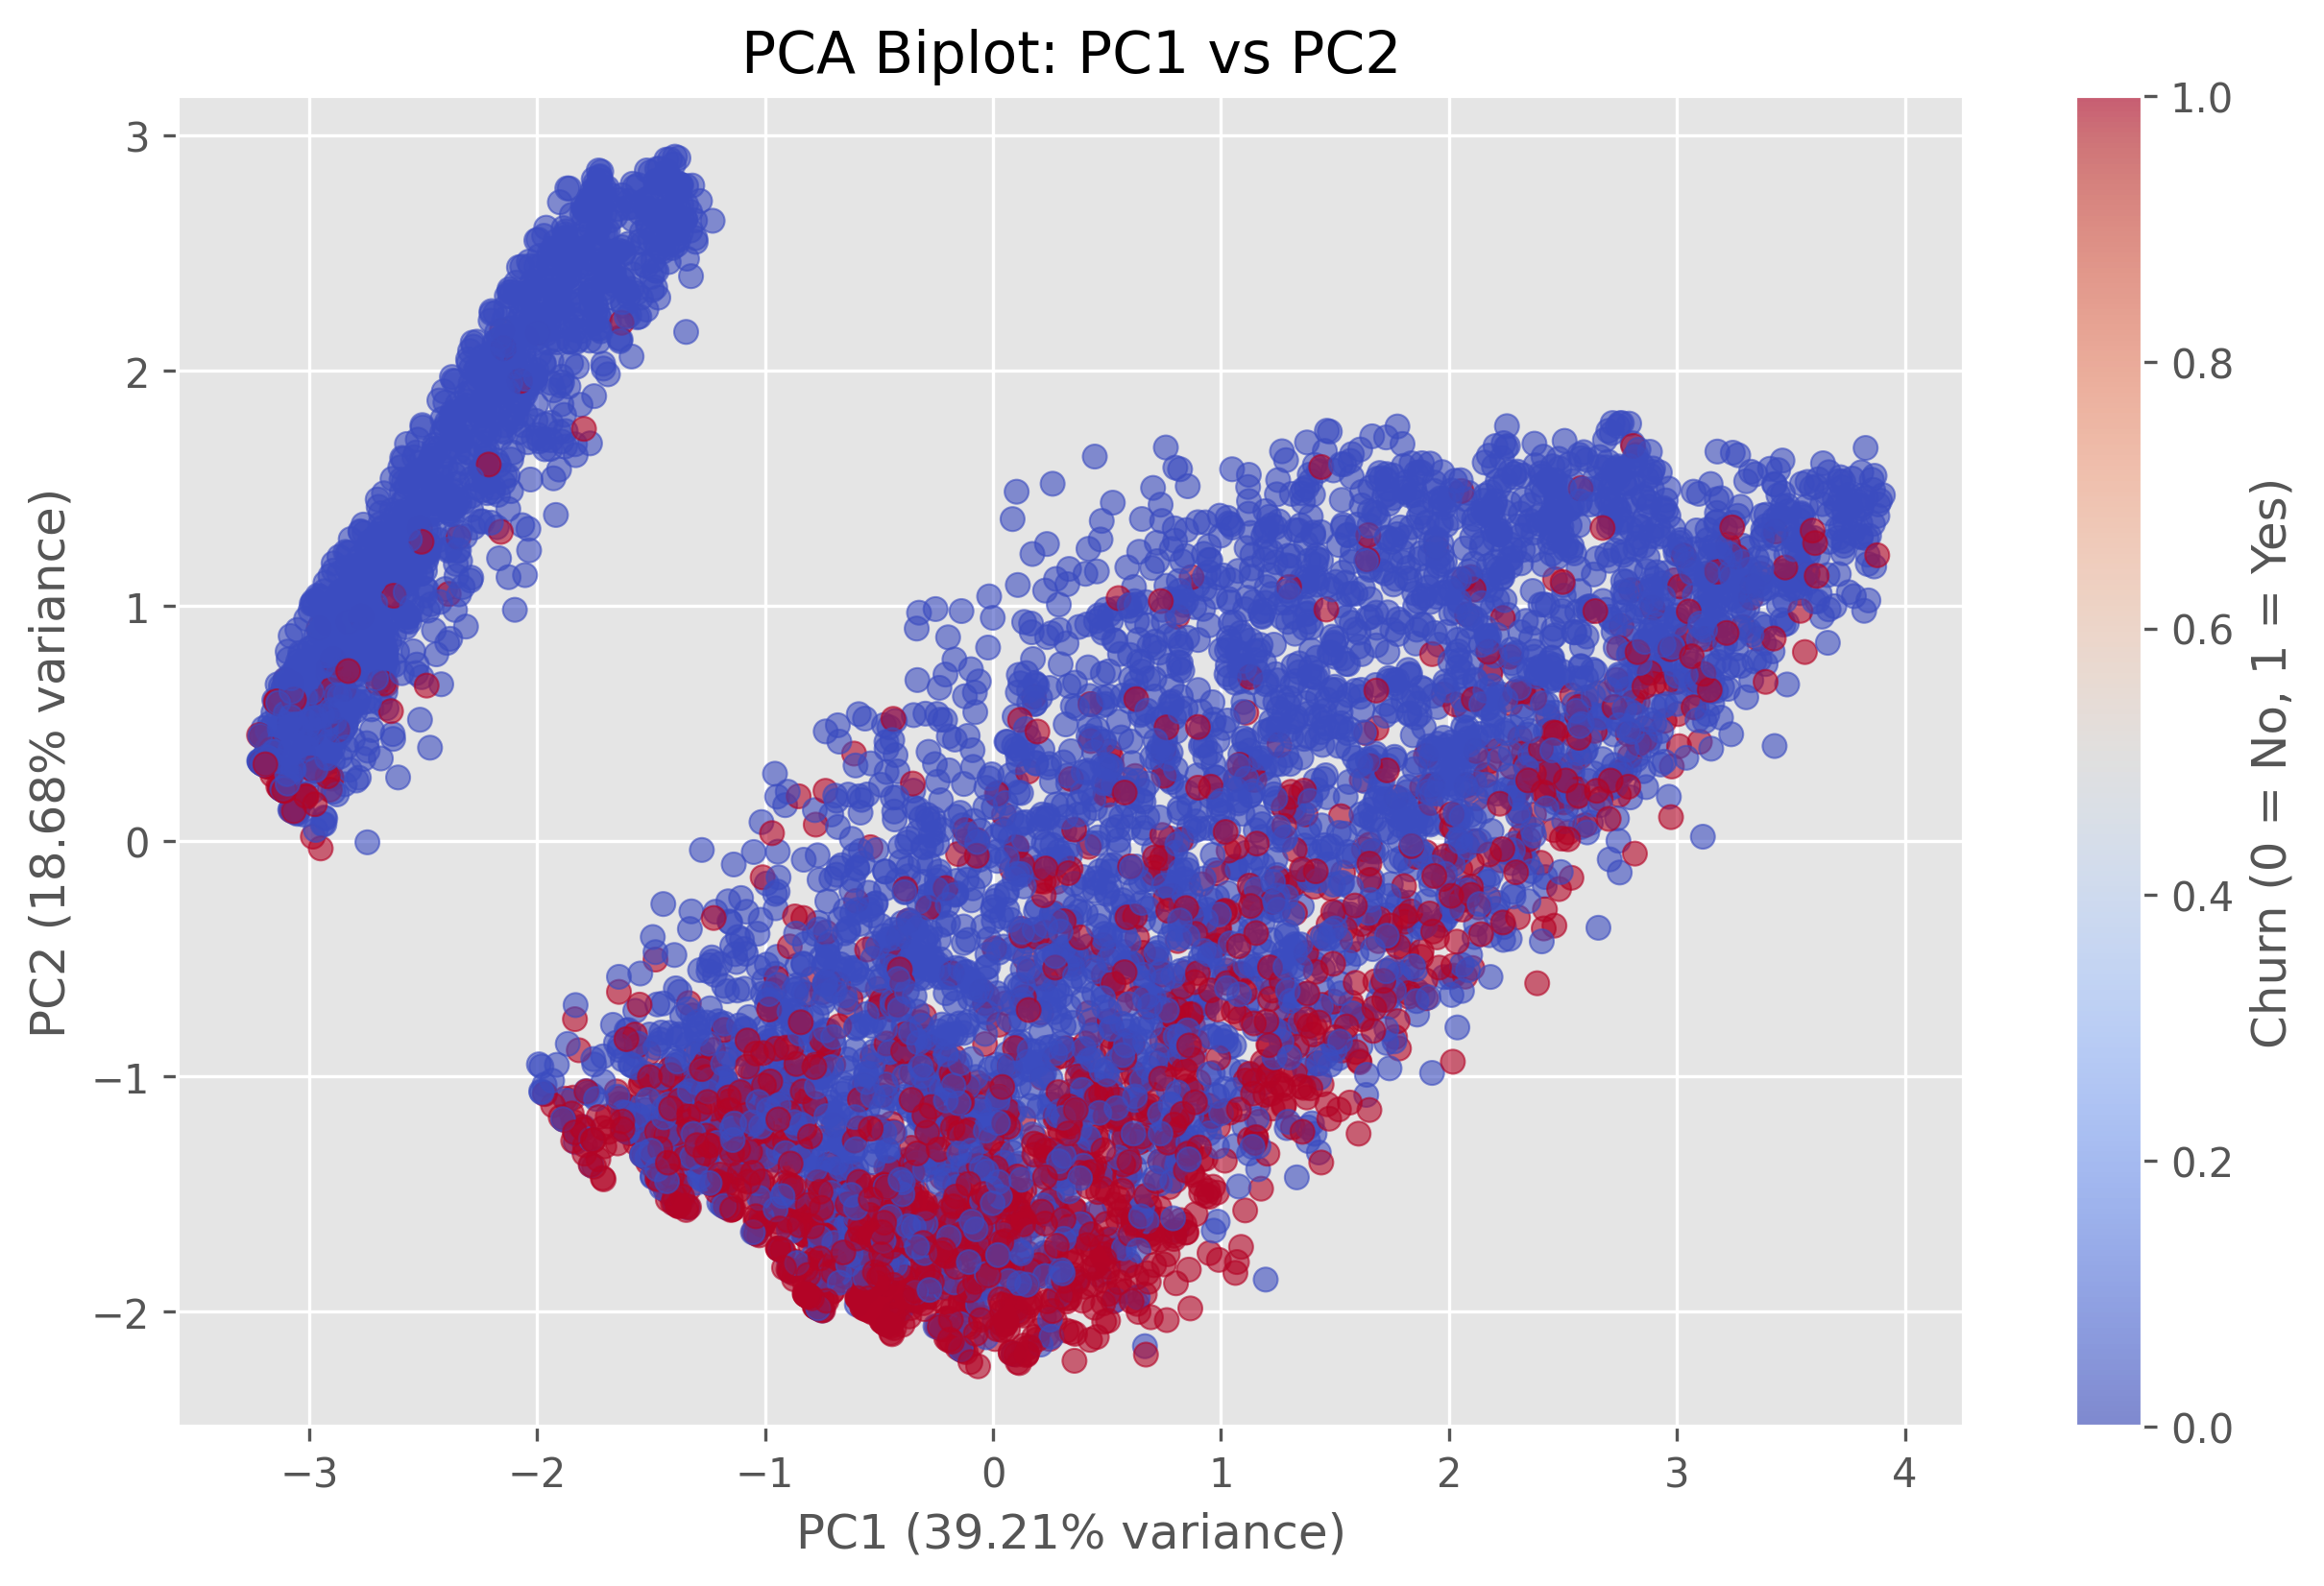

File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\pca_loadings.csv


,Unnamed: 0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,SeniorCitizen,0.038489,-0.048880,0.094750,-0.116766,0.162206,-0.014665,-0.031267,0.024389,0.017598,...,0.004929,0.038638,-0.000154,4.718554e-17,-4.545778e-17,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,5.079488e-17
1,tenure,0.333221,0.614941,-0.065319,-0.209123,0.284571,-0.021344,-0.080620,0.038927,-0.069594,...,0.089738,-0.426248,0.001114,-6.688359e-17,1.390978e-16,-2.067243e-15,-3.079181e-15,2.197349e-15,2.818968e-15,-7.247828e-16
2,MonthlyCharges,0.502087,-0.275821,0.305436,0.134640,-0.232410,0.022307,-0.007155,-0.032503,-0.000884,...,0.047069,-0.109583,0.649629,2.057640e-13,-2.167029e-13,1.344535e-13,1.855895e-13,-1.513510e-13,-1.699703e-13,2.315479e-13
3,TotalCharges,0.490803,0.340182,0.081935,-0.096199,-0.068594,0.024511,0.012766,0.096099,-0.092378,...,-0.134997,0.376999,-0.001453,-2.879191e-17,-7.448342e-17,1.443191e-15,2.190356e-15,-1.370800e-15,-1.998294e-15,7.395241e-16
4,gender_Male,-0.002561,0.004595,-0.007991,-0.010790,0.094912,0.990724,-0.021659,-0.065782,0.035193,...,-0.007840,-0.001131,-0.000518,-2.377028e-16,2.474161e-16,-4.774578e-15,-6.941564e-15,5.459759e-15,6.204795e-15,-3.550672e-16


In [12]:
# Step 3: Principal Component Analysis
print("\nStep 3: Principal Component Analysis")
X = data.drop(columns=['Churn'])
pca = PCA()
X_pca = pca.fit_transform(X)
pve = pca.explained_variance_ratio_
cumulative_pve = np.cumsum(pve)

pve_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(pve))],
    'PVE': pve,
    'Cumulative PVE': cumulative_pve
})
pve_path = os.path.join(BASE_DIR, "pca_pve.csv")
pve_df.to_csv(pve_path, index=False)
verify_and_display_file(pve_path)

plt.figure()
plt.plot(range(1, len(pve) + 1), pve, marker='o', color='b')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
scree_path = os.path.join(BASE_DIR, "scree_plot.png")
plt.savefig(scree_path, dpi=300, bbox_inches='tight')
plt.close()
verify_and_display_file(scree_path, is_image=True)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['Churn'], cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Churn (0 = No, 1 = Yes)')
plt.title('PCA Biplot: PC1 vs PC2')
plt.xlabel(f'PC1 ({pve[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pve[1]:.2%} variance)')
biplot_path = os.path.join(BASE_DIR, "pca_biplot.png")
plt.savefig(biplot_path, dpi=300, bbox_inches='tight')
plt.close()
verify_and_display_file(biplot_path, is_image=True)

loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(X.shape[1])], index=X.columns)
loadings_path = os.path.join(BASE_DIR, "pca_loadings.csv")
loadings.to_csv(loadings_path)
verify_and_display_file(loadings_path)


Step 4: Classification
KNN (k=3) 5-fold CV accuracy: 0.7446 (±0.0080)
KNN (k=5) 5-fold CV accuracy: 0.7655 (±0.0067)
KNN (k=7) 5-fold CV accuracy: 0.7739 (±0.0079)
KNN (k=10) 5-fold CV accuracy: 0.7836 (±0.0112)
File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\rf_feature_importance.csv


,Feature,Importance
0,TotalCharges,0.189701
1,tenure,0.175710
2,MonthlyCharges,0.172418
3,InternetService_Fiber optic,0.036053
4,PaymentMethod_Electronic check,0.035302



Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1036
           1       0.65      0.50      0.57       373

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409

File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\confusion_matrix_knn.png


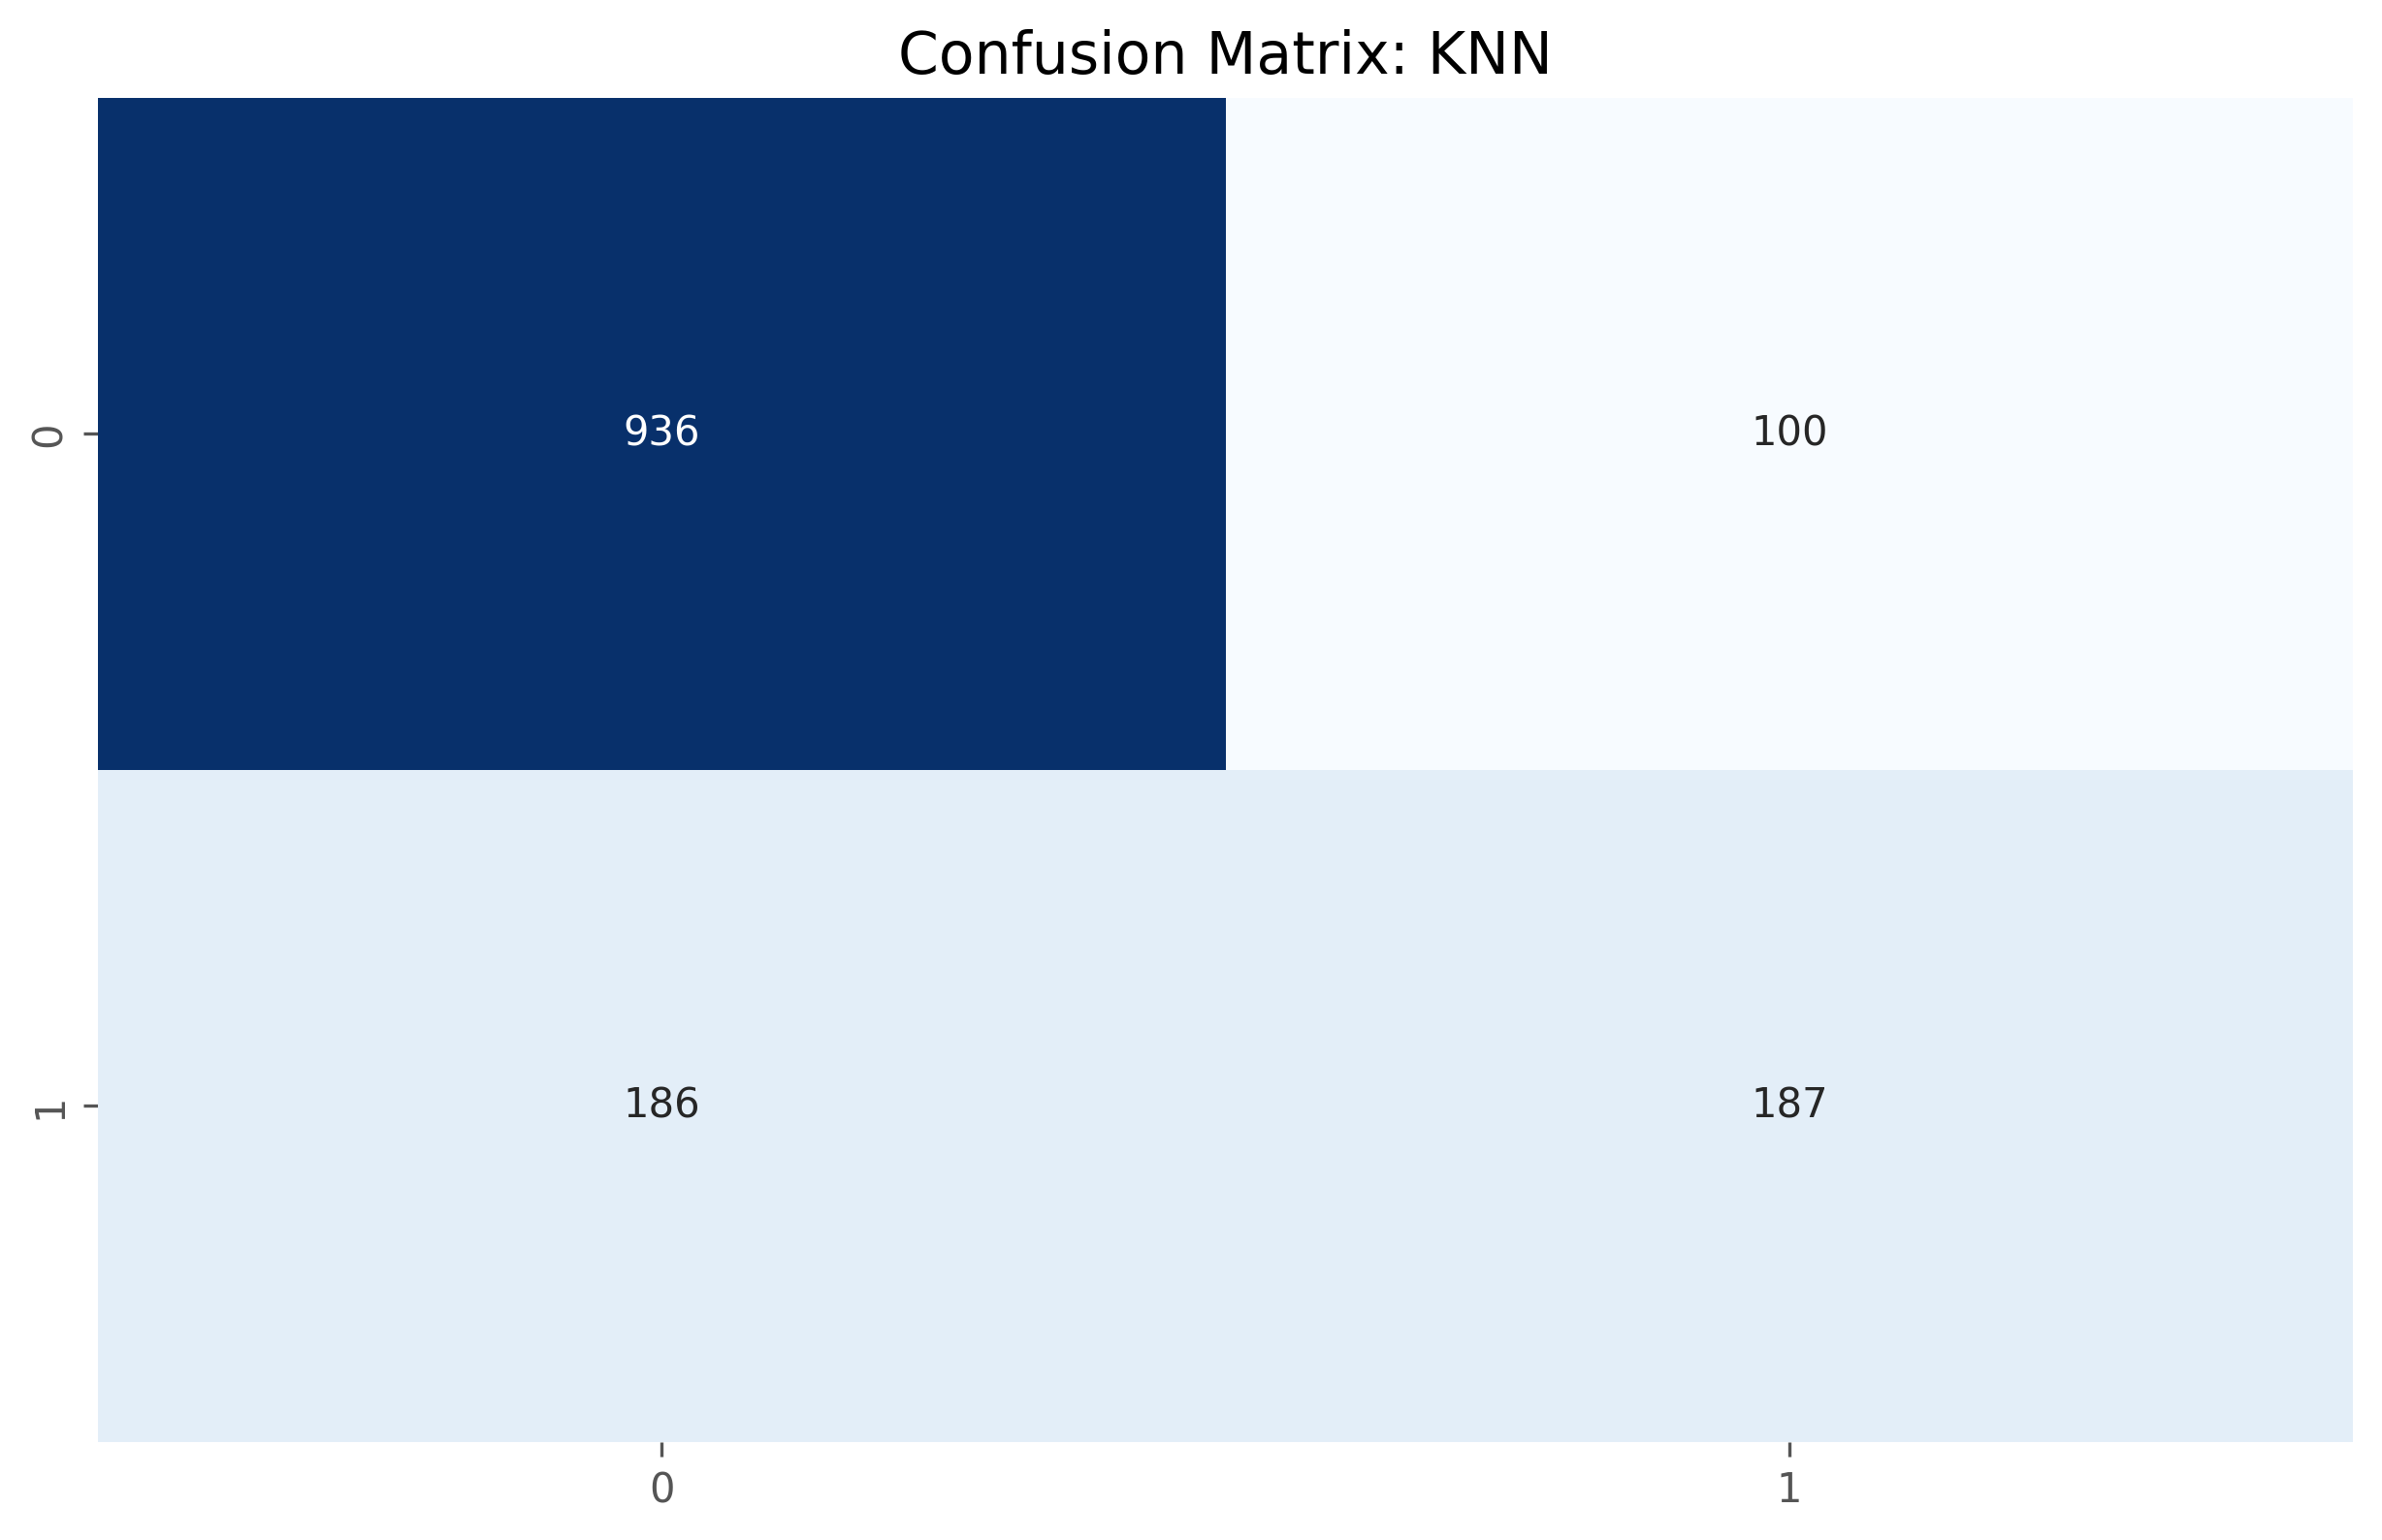


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1036
           1       0.65      0.46      0.54       373

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409

File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\confusion_matrix_random_forest.png


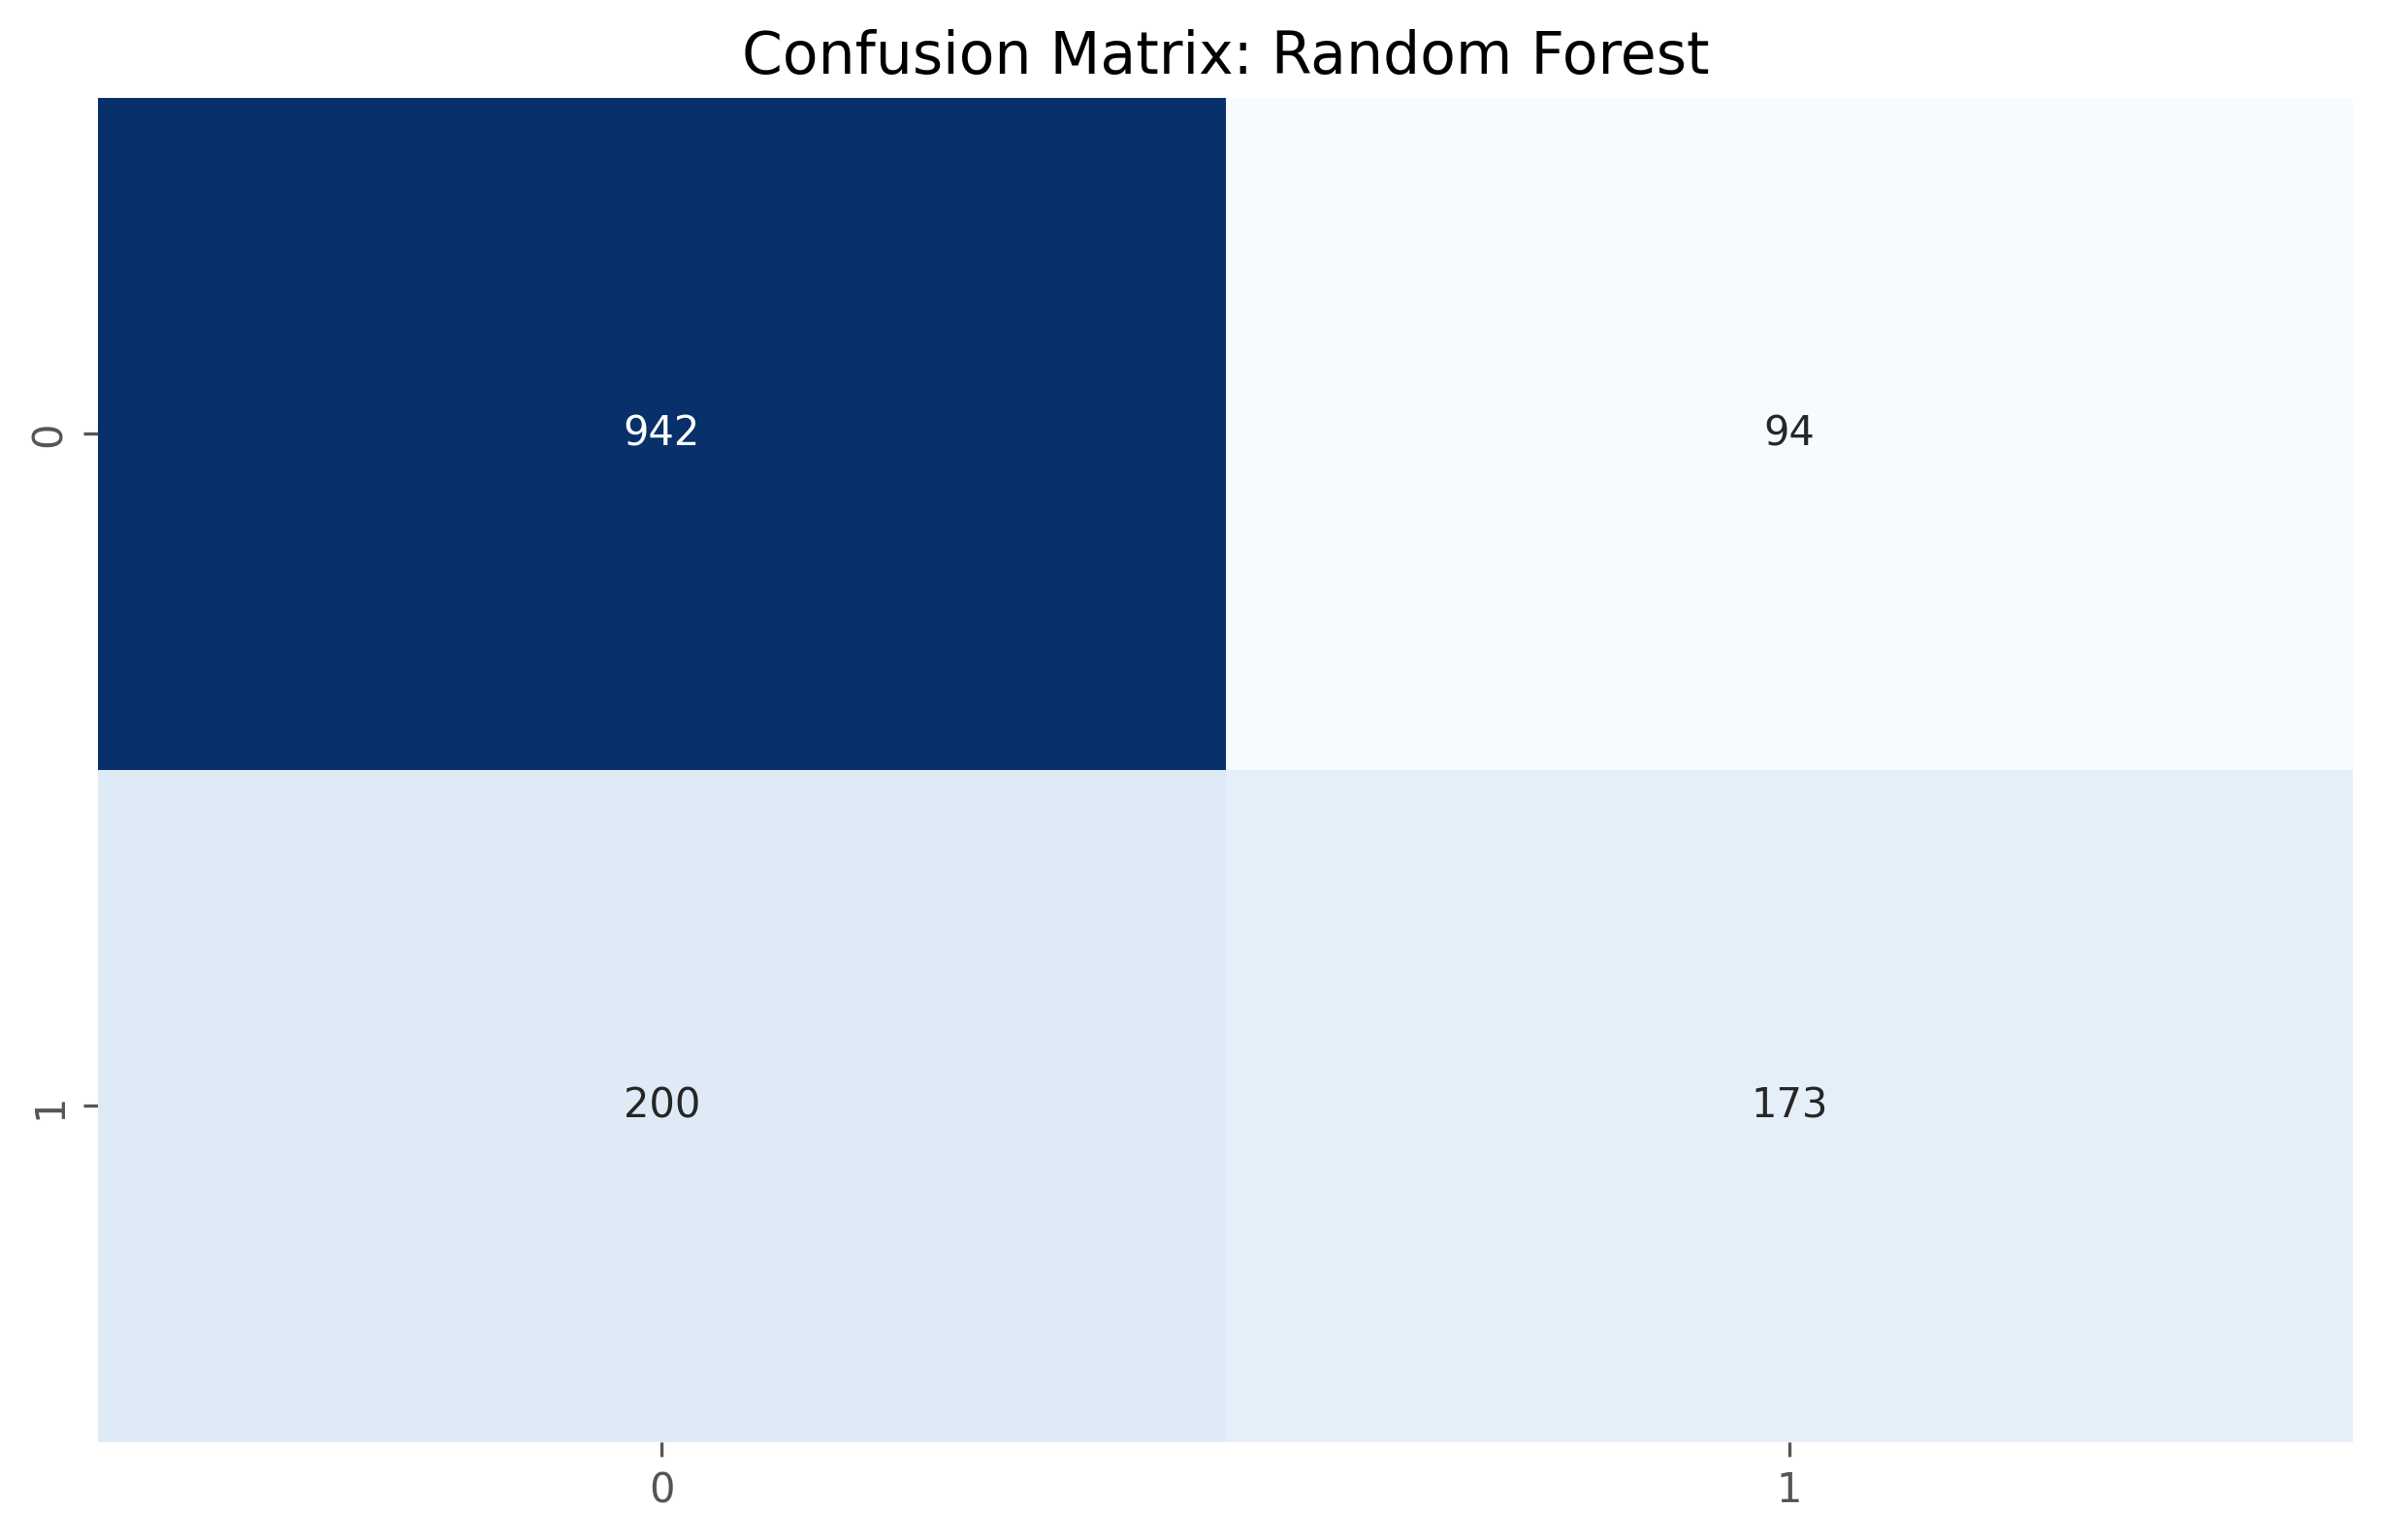


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409

File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\confusion_matrix_logistic_regression.png


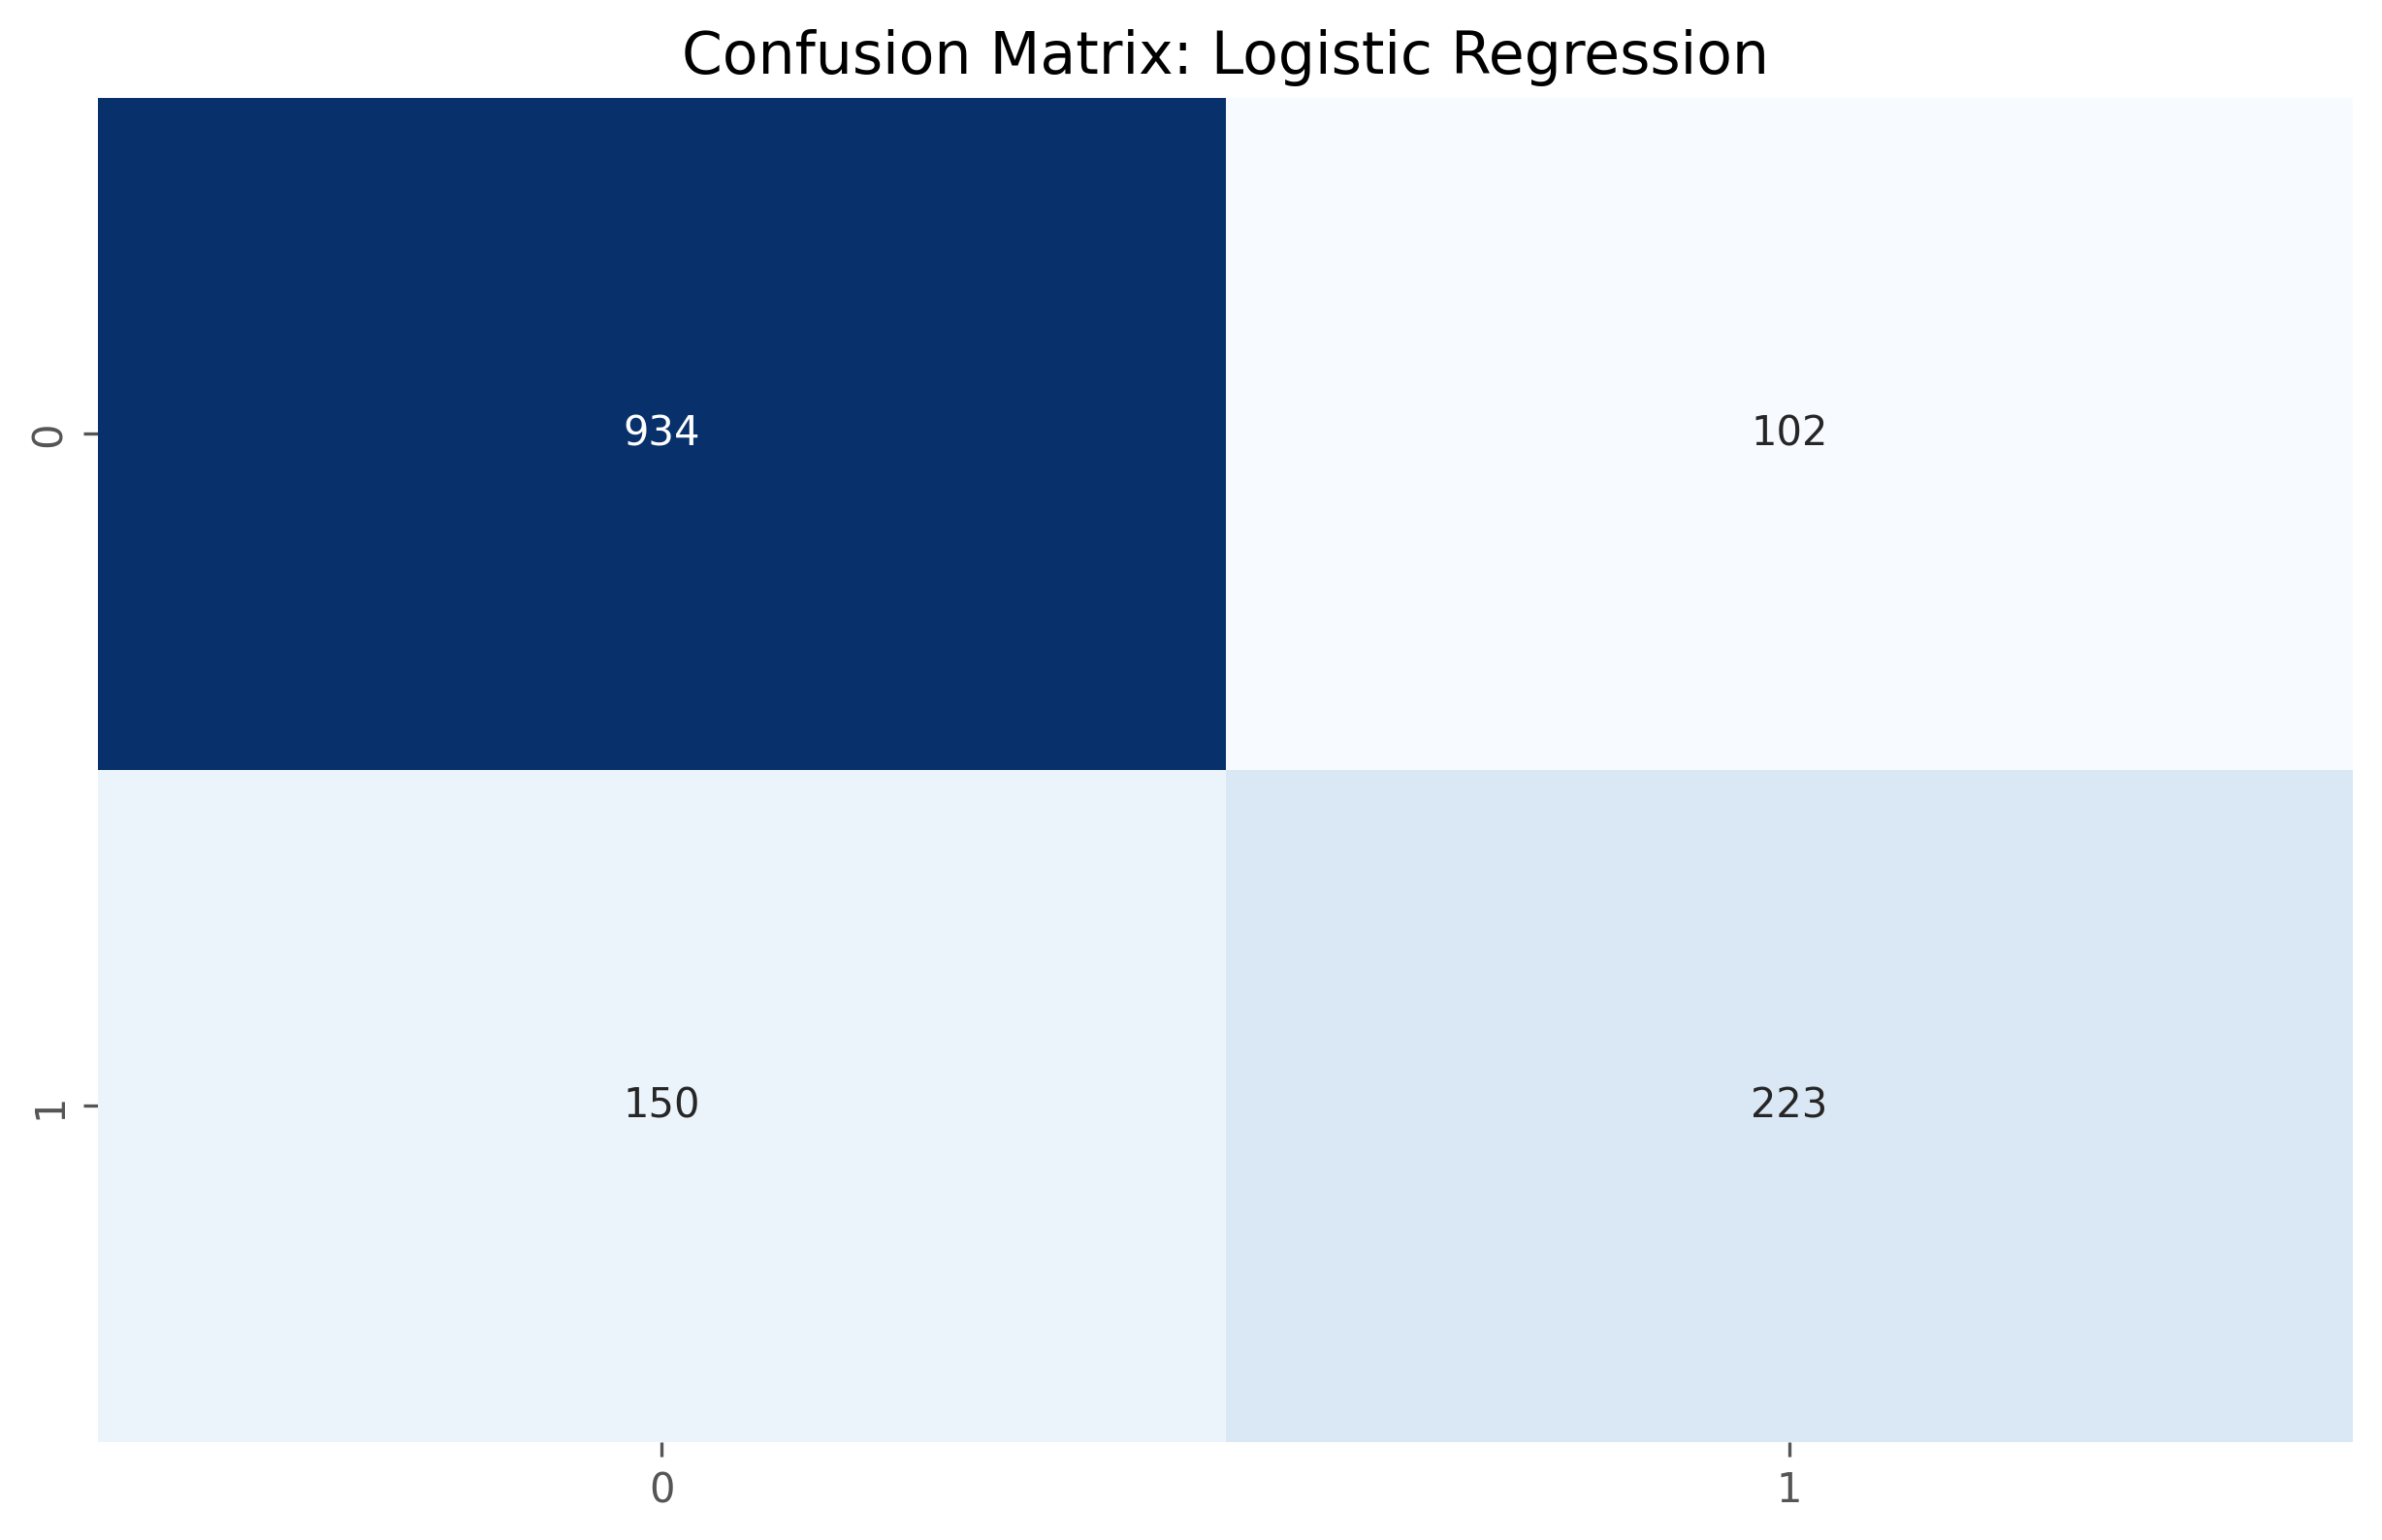

File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\classification_metrics.csv


,Model,Accuracy,Sensitivity,Specificity,AUC
0,KNN,0.797019,0.501340,0.903475,0.702408
1,Random Forest,0.791341,0.463807,0.909266,0.686537
2,Logistic Regression,0.821150,0.597855,0.901544,0.749700


File saved successfully: C:\Users\Lewis\Documents\High_Dimensional_Stat_Project\roc_curves.png


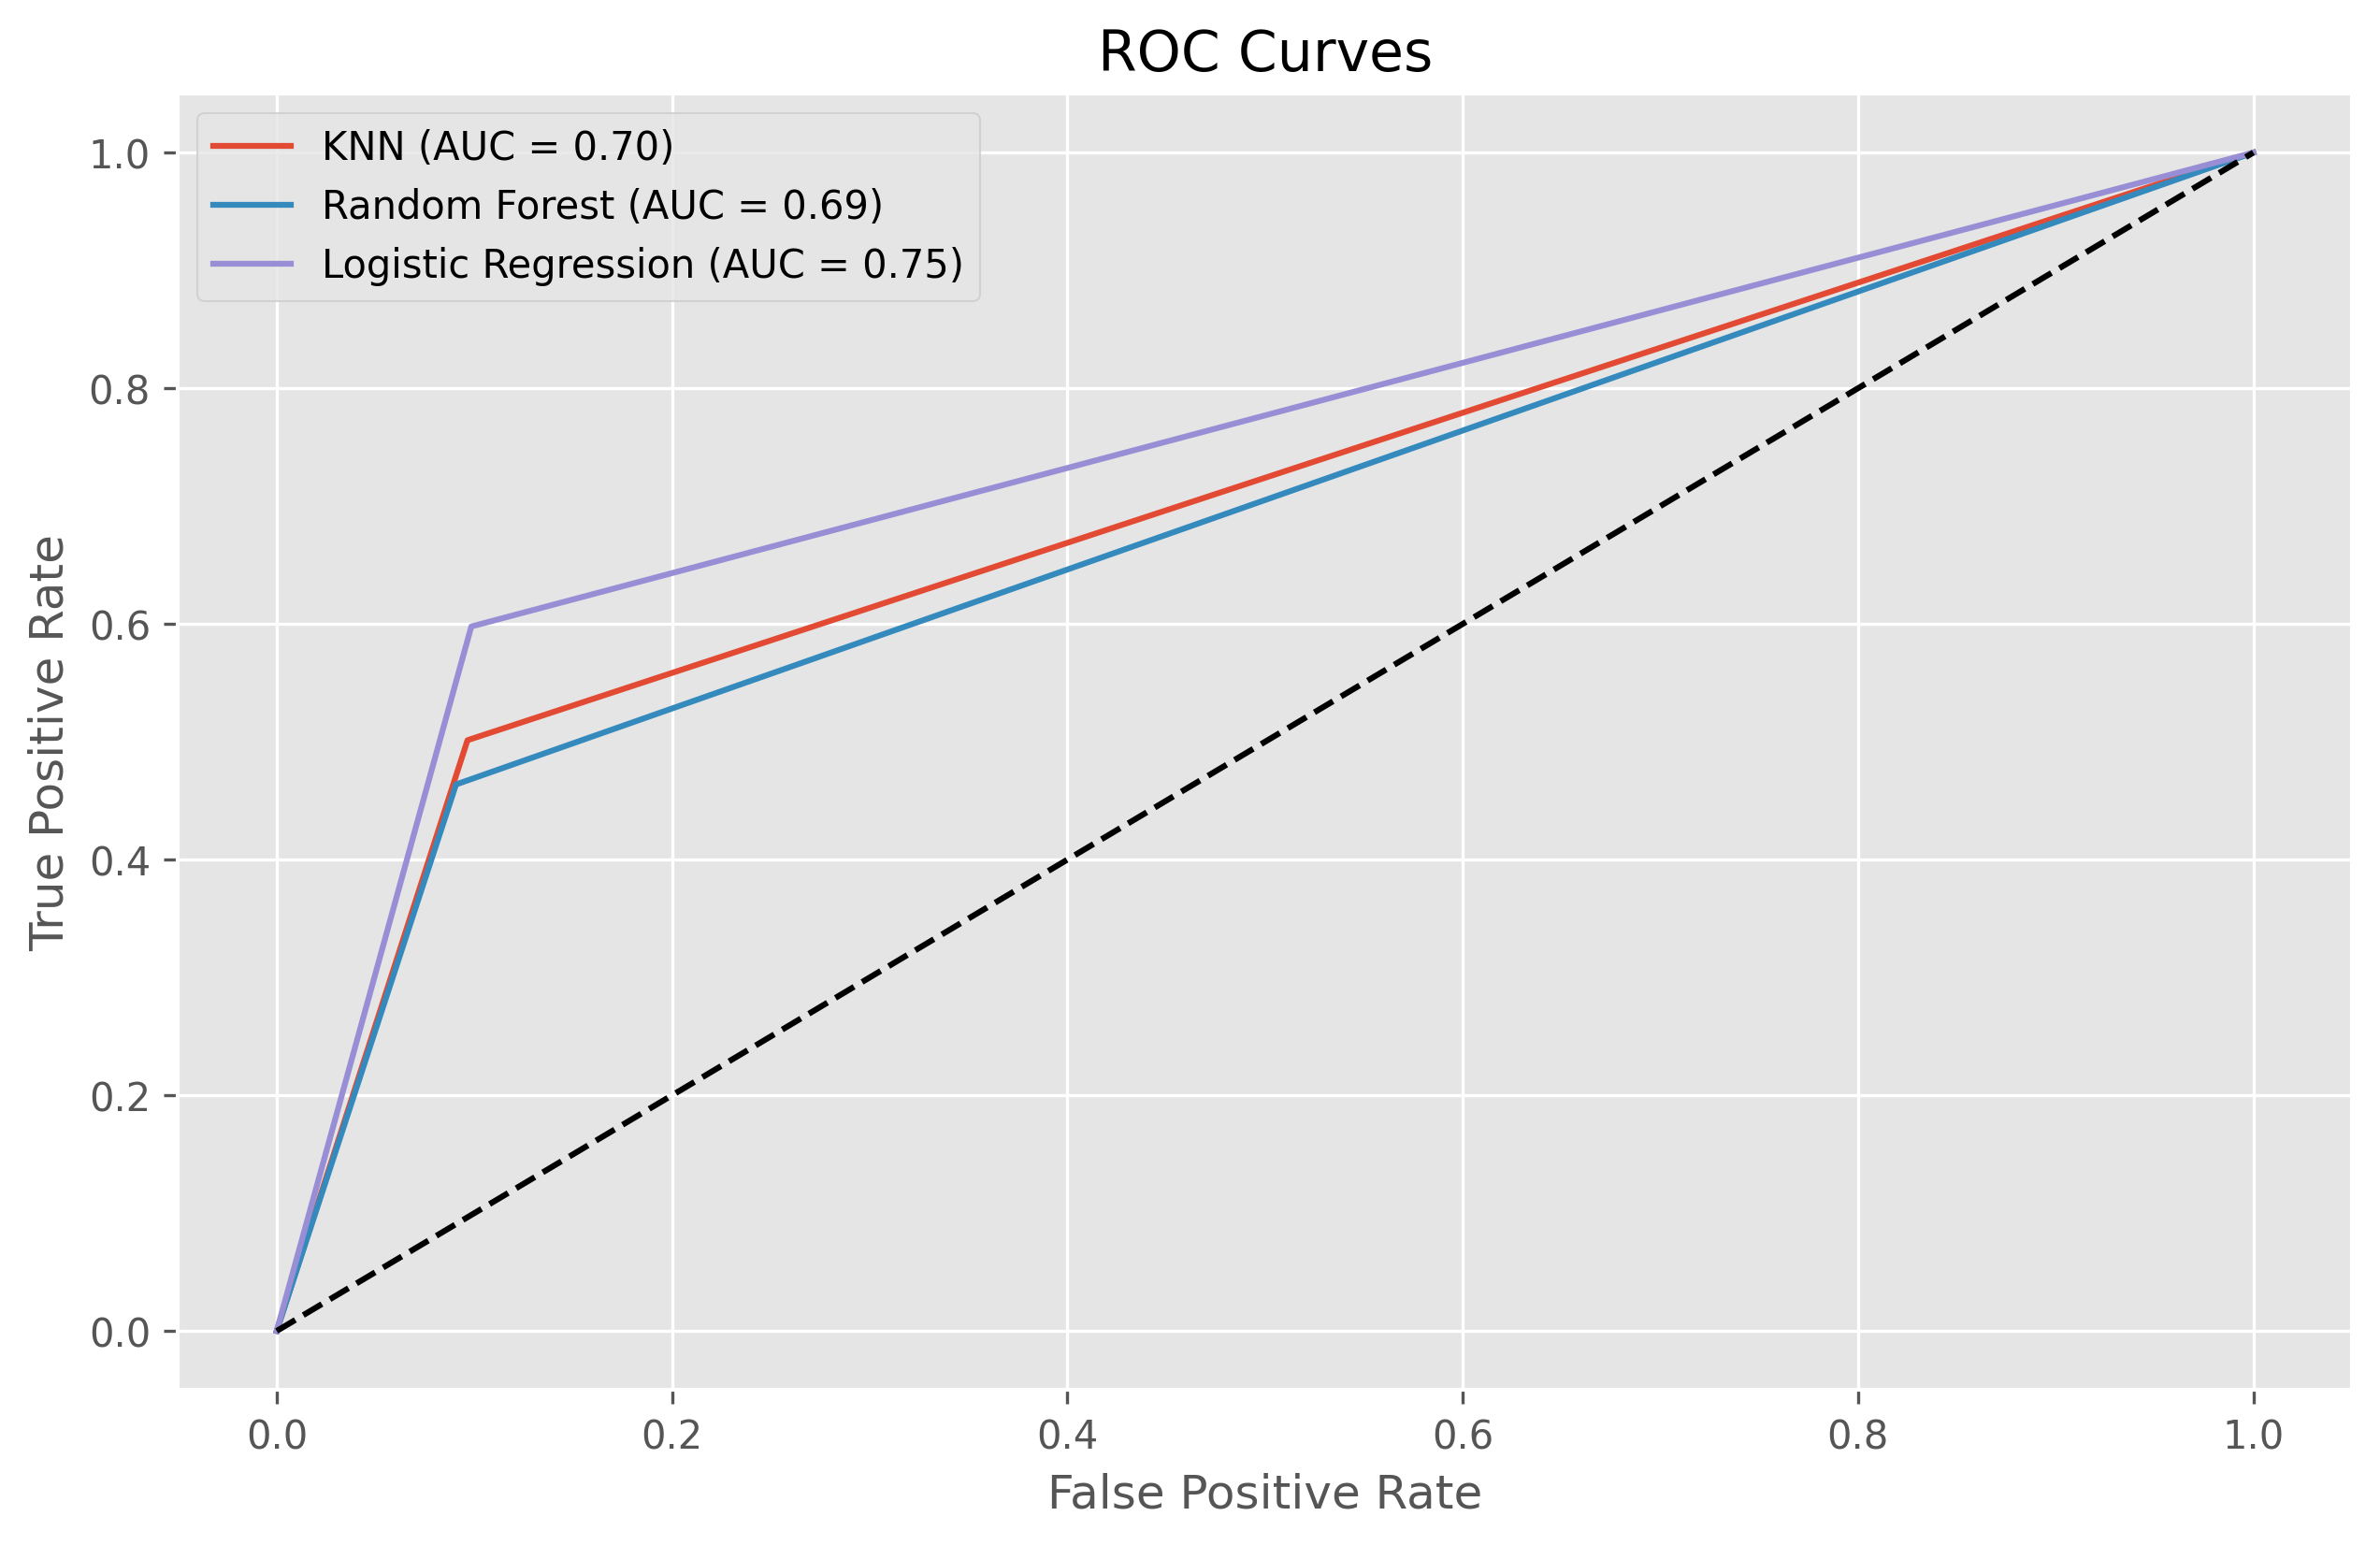

In [13]:
# Step 4: Classification
print("\nStep 4: Classification")
X_train, X_test, y_train, y_test = train_test_split(X, data['Churn'], test_size=0.2, random_state=42)

# KNN
k_values = [3, 5, 7, 10]
knn_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    knn_scores.append(cv_scores.mean())
    print(f"KNN (k={k}) 5-fold CV accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
best_k = k_values[np.argmax(knn_scores)]
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
feature_importance_path = os.path.join(BASE_DIR, "rf_feature_importance.csv")
feature_importance.to_csv(feature_importance_path, index=False)
verify_and_display_file(feature_importance_path)

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluate models
models = {'KNN': y_pred_knn, 'Random Forest': y_pred_rf, 'Logistic Regression': y_pred_lr}
metrics = []
for name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    auc = roc_auc_score(y_test, y_pred)
    metrics.append({
        'Model': name,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'AUC': auc
    })
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {name}')
    cm_path = os.path.join(BASE_DIR, f"confusion_matrix_{name.lower().replace(' ', '_')}.png")
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    plt.close()
    verify_and_display_file(cm_path, is_image=True)

metrics_df = pd.DataFrame(metrics)
metrics_path = os.path.join(BASE_DIR, "classification_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)
verify_and_display_file(metrics_path)

plt.figure()
for name, y_pred in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
roc_path = os.path.join(BASE_DIR, "roc_curves.png")
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
plt.close()
verify_and_display_file(roc_path, is_image=True)

In [20]:
# Step 5.1: Load previous outputs
# Preprocessed dataset for overall churn rate
data_file = "telco_churn_preprocessed.csv"
if not os.path.exists(data_file):
    raise FileNotFoundError(f"The file {data_file} does not exist. Please check the path and try again.")
data = pd.read_csv(data_file)

# EDA outputs
numerical_summary = pd.read_csv("numerical_summary.csv")
churn_rates = pd.read_csv("churn_rates_by_categorical.csv")

# PCA outputs
pve_df = pd.read_csv("pca_pve.csv")
loadings = pd.read_csv("pca_loadings.csv")

# Classification outputs
metrics_df = pd.read_csv("classification_metrics.csv")
feature_importance = pd.read_csv("rf_feature_importance.csv")

# Step 5.2: Summarize key findings
print("Summary of Key Findings:")
print("\nExploratory Data Analysis:")
overall_churn_rate = data['Churn'].mean() * 100
print(f"- Overall churn rate: {overall_churn_rate:.2f}%")
print("- High churn rates for month-to-month contracts (42.71%), fiber optic users (41.89%), electronic check payments (45.29%), and senior citizens (41.68%).")
print("- Numerical features (tenure, MonthlyCharges, TotalCharges) show varied distributions, with tenure skewed toward shorter durations.")

print("\nPrincipal Component Analysis:")
print(f"- PC1 explains {pve_df['PVE'][0]*100:.2f}% of variance, driven by MonthlyCharges, TotalCharges, and tenure.")
print(f"- PC2 explains {pve_df['PVE'][1]*100:.2f}% (cumulative {pve_df['Cumulative PVE'][1]*100:.2f}%), influenced by tenure and Contract_Two year.")
print("- Biplot shows separation between churned and non-churned customers, with PC1 reflecting billing patterns.")

print("\nClassification:")
print(f"- Logistic Regression achieved the highest accuracy ({metrics_df[metrics_df['Model'] == 'Logistic Regression']['Accuracy'].values[0]:.2f}).")
print(f"- Random Forest accuracy: {metrics_df[metrics_df['Model'] == 'Random Forest']['Accuracy'].values[0]:.2f}, with top features: {', '.join(feature_importance['Feature'].head(3).tolist())}.")
print(f"- KNN (k=10) accuracy: {metrics_df[metrics_df['Model'] == 'KNN']['Accuracy'].values[0]:.2f}.")
print("- ROC curves indicate strong performance across models, with Logistic Regression leading in AUC.")

# Step 5.3: Business implications
business_implications = """
Business Implications:
The analysis identifies customers with month-to-month contracts, high monthly charges, short tenure, and fiber optic services as most likely to churn. PCA highlights billing-related features (MonthlyCharges, TotalCharges) and tenure as dominant patterns, corroborated by Random Forest's feature importance. To reduce churn, the telecommunications company should:
1. Offer loyalty programs or discounts for customers with tenure less than 12 months to enhance retention.
2. Promote one-year or two-year contracts with incentives, given their low churn rates (11.27% and 2.83%).
3. Improve fiber optic service quality or offer bundled discounts to address high churn (41.89%).
4. Encourage alternative payment methods for electronic check users (45.29% churn) to improve convenience.
These strategies can lower churn rates, boosting customer retention and revenue stability.
"""

print("\n" + business_implications)

# Step 5.4: Executive summary (≤150 words)
executive_summary = """
Executive Summary:
Analysis of the Telco Customer Churn dataset using PCA and classification methods reveals key churn drivers. PCA shows MonthlyCharges, TotalCharges, and tenure explaining 39.21% of variance in PC1, with tenure and contract type driving PC2 (18.68%). Logistic Regression achieved the highest accuracy (0.82), followed by Random Forest (0.79) and KNN (0.80). Random Forest identifies TotalCharges, tenure, and MonthlyCharges as top predictors. Customers with month-to-month contracts (42.71% churn), fiber optic services (41.89%), and electronic check payments (45.29%) are most at risk. Recommended strategies include loyalty programs for short-tenure customers, promoting longer-term contracts, improving fiber optic services, and streamlining payment options. These measures can reduce churn, enhancing customer retention and financial performance.
(Word count: 126)
"""

print("\n" + executive_summary)

# Step 5.5: Save narrative for report
with open("business_implications.txt", "w") as f:
    f.write("Summary of Key Findings:\n")
    f.write("\nExploratory Data Analysis:\n")
    f.write(f"- Overall churn rate: {overall_churn_rate:.2f}%\n")
    f.write("- High churn rates for month-to-month contracts (42.71%), fiber optic users (41.89%), electronic check payments (45.29%), and senior citizens (41.68%).\n")
    f.write("- Numerical features (tenure, MonthlyCharges, TotalCharges) show varied distributions, with tenure skewed toward shorter durations.\n")
    f.write("\nPrincipal Component Analysis:\n")
    f.write(f"- PC1 explains {pve_df['PVE'][0]*100:.2f}% of variance, driven by MonthlyCharges, TotalCharges, and tenure.\n")
    f.write(f"- PC2 explains {pve_df['PVE'][1]*100:.2f}% (cumulative {pve_df['Cumulative PVE'][1]*100:.2f}%), influenced by tenure and Contract_Two year.\n")
    f.write("- Biplot shows separation between churned and non-churned customers, with PC1 reflecting billing patterns.\n")
    f.write("\nClassification:\n")
    f.write(f"- Logistic Regression achieved the highest accuracy ({metrics_df[metrics_df['Model'] == 'Logistic Regression']['Accuracy'].values[0]:.2f}).\n")
    f.write(f"- Random Forest accuracy: {metrics_df[metrics_df['Model'] == 'Random Forest']['Accuracy'].values[0]:.2f}, with top features: {', '.join(feature_importance['Feature'].head(3).tolist())}.\n")
    f.write(f"- KNN (k=10) accuracy: {metrics_df[metrics_df['Model'] == 'KNN']['Accuracy'].values[0]:.2f}.\n")
    f.write("- ROC curves indicate strong performance across models, with Logistic Regression leading in AUC.\n")
    f.write("\n" + business_implications)
    f.write("\n" + executive_summary)
print("\nBusiness implications and executive summary saved to: business_implications.txt")

Summary of Key Findings:

Exploratory Data Analysis:
- Overall churn rate: 26.54%
- High churn rates for month-to-month contracts (42.71%), fiber optic users (41.89%), electronic check payments (45.29%), and senior citizens (41.68%).
- Numerical features (tenure, MonthlyCharges, TotalCharges) show varied distributions, with tenure skewed toward shorter durations.

Principal Component Analysis:
- PC1 explains 39.21% of variance, driven by MonthlyCharges, TotalCharges, and tenure.
- PC2 explains 18.68% (cumulative 57.89%), influenced by tenure and Contract_Two year.
- Biplot shows separation between churned and non-churned customers, with PC1 reflecting billing patterns.

Classification:
- Logistic Regression achieved the highest accuracy (0.82).
- Random Forest accuracy: 0.79, with top features: TotalCharges, tenure, MonthlyCharges.
- KNN (k=10) accuracy: 0.80.
- ROC curves indicate strong performance across models, with Logistic Regression leading in AUC.


Business Implications:
The a